# Realistic and controlled image generation using Generative Adversarial Networks and Variational Autoencoders 

-------------------------

## Part 1 - training the model   

----------------------------

## Abstract

This work presents a method of uniting Generative Adversarial Networks with Variational Autoencoders for generating realistic and controllable images.   
Generative Adversarial Networks (GANs) are neural networks capable of generating realistic images from the competition between a generator and a discriminator models. However, traditional GANs do not offer control over the generated images, using random inputs.   
Variational Autoencoders (VAEs) are models capable of reducing an image to a group of parameters and then recreate the image from these parameters. However, without additional mechanisms, the generated images do not have the sharpness or the perfection of a real image.   
Joining both models described makes it possible to generate images that are either realistic and controllable by chosen parameters.    
Using an image database of handwritten numbers (MNIST), we apply the proposed method to extract and use parameters in order to generate chosen numbers with desired traits.   






# Introduction - Training the model

With the objective of producing high quality images with desired traits, we are going to train a neural network model.

We are going to associate a Generative Adversarial Network (GAN), known for producing high quality images; and a Variational Autoencoder (VAE), known for creating encoded parameters capable of reproducing an input and transition gradually from one type of input to another as the parameters are changed.   

More details on those models can be found in their respective papers:   

- [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).  
- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661).

For this project, we will use the MNIST database of handwritten numbers. 


## The Variational Autoencoder (VAE)

An autoencoder is a neural network composed by two submodels:

- An encoder: converts an input image into a compact set of numeric parameters (encodings).    
- A decoder: converts the encodings back to the original image.    
- A loss function that compares the input image with the output image.   

The distinction between a VAE and a simple autoencoder happens in how the encodings are treated:

- The outputs of the encoder are "means" and "standard deviations" of normal distributions.   
- The inputs to the decoder are "random samples from normal distributions" whose parameters are the outputs of the encoder.    
- A loss function named Kullback-Leibler loss is used to keep the encodings close to a standard normal distribution.  

These differences guarantee that the encoded parameters are gradually distributed, withouth holes or big separation between desired classes. This allows us to gradually change encodings and see the output images gradually changing between classes. 


## The Generative Adversarial Network (GAN)

A GAN is a network also containing two submodels, but in a GAN, these models compete against each other:

- A Generator: tries to produce images that can be interpreted as real by the other model (discriminator).   
- A Discriminator: tries to identify among original images and generated images which are the fake (generated) ones.    

The competition between the two models leads to an increasing quality of the generated images, up to the point that they are as good as the original images.   

## Using the models combined

A regular GAN can produce high quality images, but it's not possible to control what type of images are going to be generated.    
On the other hand, the Decoder side of a VAE allows control of what is being generated (by adjusting the encodings), but the generated images don't have high quality (unless special loss functions are used for this purpose, usually these losses employ neural networks as well).   

By making the "VAE" be the "Generator" part of a GAN, it's possible to combine the advantages of the two models. 

In the following sections we are going to create and train a model following this idea. For more detail on the architecture, see the "Combined Models > Training Description" section of this work. 

# Imports

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Optimizer, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')
wDir = "/content/drive/My Drive/BI_Master/Projeto"

npRandom = np.random.default_rng()

Mounted at /content/drive


### Functions for plotting and checking


In [ ]:
#plots 40 images in 4 rows using the passed labels as titles - needs image range 0 to 1
def plot40(images, labels, random=True):
    if random == True:
        indices = npRandom.choice(len(images), 40)
    else:
        indices = np.arange(40)

    images = images[indices].reshape((4,10) + images.shape[1:-1])
    if labels is not None:
        labels = labels[indices].reshape((4,10) + labels.shape[1:])
    plotArray(images, labels)

#takes an array of images, shape (rows, columns, img_width, img_height)
#titlesArray are the captions of the images (rows, columns)
def plotArray(imagesArray, titlesArray): 
    shp = imagesArray.shape[:2]
    
    fig, ax = plt.subplots(nrows=shp[0], ncols=shp[1], squeeze=False, figsize=(20,3*shp[0]))
    for i in range(shp[0]):
        for j in range(shp[1]):
            ax[i,j].imshow(imagesArray[i,j], vmin=0, vmax=1)
            if titlesArray is not None:
                ax[i,j].set_title(titlesArray[i,j])
            ax[i,j].set_axis_off()
            
    plt.show()



def printRange(arr, name):
    print("Range of ", name)
    print(arr.min(), "to", arr.max())

### Layer groups / Custom layers

Creates a group of layers, adding a Batch Normalization after the desired layer and placing the activation at the end. 

Using batch normalization before activations prevent "freezing relu" and "saturating sigmoid/tanh".

In [ ]:
# Adds batch normalization after a given layer and before the given activation
def wrapBN(inputs, layer, activation):

    outs = layer(inputs)
    outs = BatchNormalization(name='bn_' + layer.name)(outs)
    if activation is not None:
        outs = Activation(activation, name='act_'+layer.name)(outs)
    return outs
    

### Load data

Here we load and visualize the MNIST dataset, separated in train and test data.
Analysing the dataset is not in the scope of this project.   

In [ ]:
(xTrain, yTrain), (xTest, yTest) = load_data()
print("Shapes:")
print("xTrain & yTrain", xTrain.shape, yTrain.shape)
print("xTest & yTest", xTest.shape, yTest.shape)

print("\nRanges:")
print("x:", xTrain.min(), " - ", xTrain.max(), " --- ", xTest.min(), " - ", xTest.max())
print("y:", yTrain.min(), " - ", yTrain.max(), " --- ", yTest.min(), " - ", yTest.max())

11493376/11490434 [==============================] - 0s 0us/step
Shapes:
xTrain & yTrain (60000, 28, 28) (60000,)
xTest & yTest (10000, 28, 28) (10000,)

Ranges:
x: 0  -  255  ---  0  -  255
y: 0  -  9  ---  0  -  9


Max x: 1.0 1.0
Train images


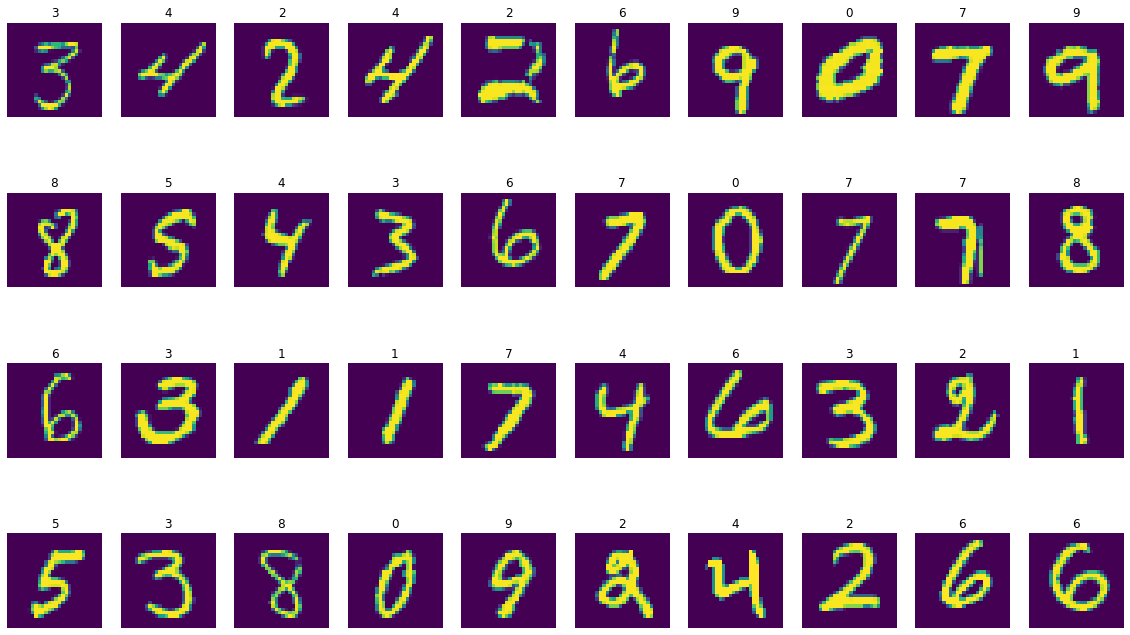




Test images


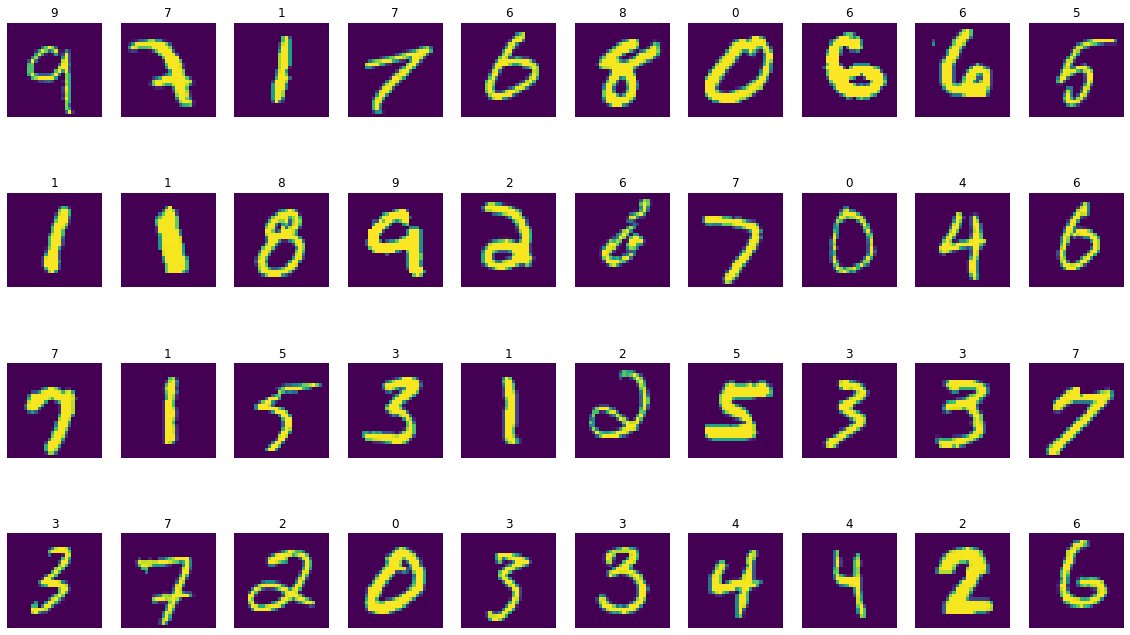

In [ ]:
#Normalize X
xTrain = xTrain.astype("float32") / 255.
xTest = xTest.astype("float32") / 255.

#Adding channels
xTrain = xTrain.reshape(-1, 28,28, 1)
xTest = xTest.reshape(-1, 28,28, 1)

#See ranges
print("Max x:", xTrain.max(), xTest.max())

#Plotting train samples
print("Train images")
plot40(xTrain, yTrain)
print("\n\n\nTest images")
plot40(xTest, yTest)

# Models

This is a model made of a Variational Autoencoder and a GAN
The gan has two parts:
- Generator
- Discriminator

But the "Generator" of the GAN is a Variational Autoencoder, made of:
- Encoder
- Decoder

Each submodel is a Convolutional Neural Network, their details can change freely to suit the dataset being used, desired quality, etc. 

##Encoder

Takes the images as inputs and generates means and sigmas of a normal distribution.   
Its output is a flattened array of size `encodedSize`.   

In [ ]:
encodedSize = 15
encoderInputs = Input((28,28,1), name='imageInputs', dtype='float32')

out = wrapBN(encoderInputs,Conv2D(20, 3, use_bias=False), activation='relu')#26
out = wrapBN(out,Conv2D(40, 3, use_bias=False), 'relu')#24
out = Conv2D(60, 3, use_bias=False)(out) #22
out = wrapBN(out, MaxPooling2D(), activation='relu')#11
out = wrapBN(out,Conv2D(90, 3, use_bias=False), 'relu') #9
out = wrapBN(out,Conv2D(120, 3, use_bias=False), 'relu')#7
outMean = wrapBN(out, Conv2D(200, 5, use_bias=False), activation='relu')#3
outMean = wrapBN(outMean, Conv2D(250, 3, use_bias=False), activation='relu')#1
outMean = Flatten()(outMean)

outSigma = wrapBN(out, Conv2D(300, 5, use_bias=False), activation='relu')
outSigma = wrapBN(outSigma, Conv2D(300, 3, use_bias=False), activation='relu')
outSigma = Flatten()(outSigma)

outMean = Dense(encodedSize, name='meanOut', kernel_initializer='zeros')(outMean)
outSigma = Dense(encodedSize, name='sigmaOut',kernel_initializer='zeros',  bias_initializer='ones')(outSigma)
outSigma = Lambda(lambda x: K.abs(x) + K.epsilon(), name='absSigma')(outSigma)
out = [outMean, outSigma]

      
encoderModel = Model(encoderInputs, out, name='ENCODER')
encoderModel.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imageInputs (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 20)   180         imageInputs[0][0]                
__________________________________________________________________________________________________
bn_conv2d (BatchNormalization)  (None, 26, 26, 20)   80          conv2d[0][0]                     
__________________________________________________________________________________________________
act_conv2d (Activation)         (None, 26, 26, 20)   0           bn_conv2d[0][0]                  
____________________________________________________________________________________________

## Decoder

Takes samples from a normal distribution using the means and sigmas generated by the encoder.

The sampling of the inputs is manually made in the training pass, not included in the encoder or the decoder.  

Outputs images are the same size of the original images.

In [ ]:
encodedInputs = Input((encodedSize,), name='encodedInputs', dtype='float32')

out = wrapBN(encodedInputs, Dense(7*7, use_bias=False), activation='relu')
out = wrapBN(out, Dense(7*7*15, use_bias=False), activation='relu')
out = Reshape((7,7,15))(out) #7
out = wrapBN(out, Conv2D(50,3, padding='same', use_bias=False), activation='relu')
out = UpSampling2D()(out)#14
out = wrapBN(out, Conv2D(100,3, padding='same', use_bias=False), activation='relu')
out = wrapBN(out, Conv2D(150,3, padding='same', use_bias=False), activation='relu')
out = UpSampling2D()(out) #28
out = wrapBN(out, Conv2D(100, 2, padding='same', use_bias=False), activation='relu')#7
out = wrapBN(out, Conv2D(70, 5, padding='same', use_bias=False),activation='relu')
out = wrapBN(out, Conv2D(50, 5, padding='same', use_bias=False), activation='relu')
out = wrapBN(out, Conv2D(1, 3, padding='same', use_bias=False), activation='sigmoid')

decoderModel = Model(encodedInputs, out, name='DECODER')
decoderModel.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodedInputs (InputLayer)   [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 49)                735       
_________________________________________________________________
bn_dense (BatchNormalization (None, 49)                196       
_________________________________________________________________
act_dense (Activation)       (None, 49)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 735)               36015     
_________________________________________________________________
bn_dense_1 (BatchNormalizati (None, 735)               2940      
_________________________________________________________________
act_dense_1 (Activation)     (None, 735)               0   

## Discriminator

Discriminator side of a GAN.  
Takes images as inputs, classifies images with outputs 1 for "fake" and 0 for "true".

In [ ]:
discriminatorInputs = Input((28,28,1), name='discInputs', dtype='float32')
out = wrapBN(discriminatorInputs, Conv2D(15,5, use_bias=False), activation='relu')#24
out = Conv2D(30,5, use_bias=False)(out)#20
out = wrapBN(out, MaxPooling2D(), activation='relu')#10
out = wrapBN(out, Conv2D(30,5, use_bias=False), activation='relu')#6
out = Flatten()(out)
out = wrapBN(out, Dense(20, use_bias=False), activation='relu')
out = Dense(1, activation='sigmoid')(out)

discriminatorModel = Model(discriminatorInputs, out, name='DISCRIMINATOR')
discriminatorModel.summary()

Model: "DISCRIMINATOR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discInputs (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 15)        375       
_________________________________________________________________
bn_conv2d_16 (BatchNormaliza (None, 24, 24, 15)        60        
_________________________________________________________________
act_conv2d_16 (Activation)   (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 20, 20, 30)        11250     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 30)        0         
_________________________________________________________________
bn_max_pooling2d_1 (BatchNor (None, 10, 10, 30)      

# Combined Models

Here we are going to combine the previous models into an object that performs:

- Forward pass    
- Loss calculation     
- Train pass (apply gradients to the respective weights)   


## Training description

The training method used here updates the weights of all models with a single pass (different from some methods for training GANs that separate passes for training the generator and passes for training the discriminator). 

For this to be possible, the training must be done in a custom training loop where each of the losses have their gradients calculated regarding only their respective target model weights. 

The following picture shows the training pass and calculated losses:

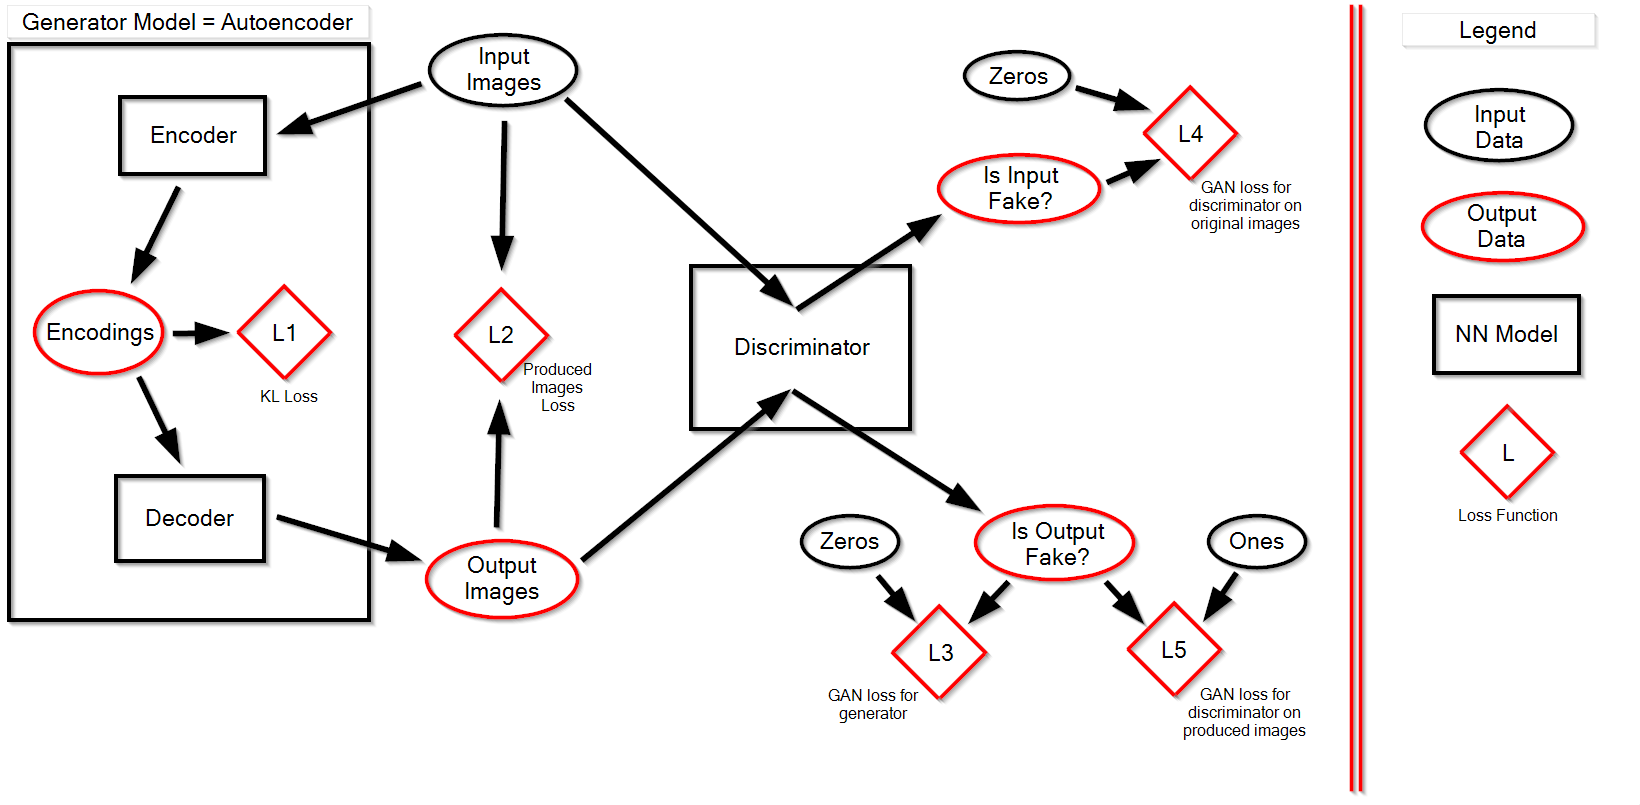

## Losses

In the picture above, each of the losses refers to a specific model, and the training gradients are calculated regarding these respective models:

- **L1 - Kullback-Leibler loss**: applies to the **Encoder weights**. Enforces that the outputs of the encoder will roughly follow a standard normal distribution.   
- **L2 - Produced images loss**: applies to the entire **Generator weights** (encoder + decoder). Compares the original input images with the produced images.   
- **L3 - GAN loss for generator**: applies to the **Generator weights** (encoder + decoder). Tries to make the generator produce images that the discriminator thinks are real.    
- **L4 - GAN loss for discriminator on original images**: applies to the **Discriminator weights**. Teaches the disciminator that the input images are real.   
- **L5 - GAN loss for discriminator on produced images**: applies to the **Disciminator weights**. Tries to make the disciminator identify the produced images as fake. 

Each of the losses receives a different "loss weight". These loss weights were experimentally selected for achieving a satisfactory result in training.

## Model

The class below implements the strategy discussed above.
This is not a "Tensorflow/Keras" model, it's just a Python object.   

The full training is made in eager mode in a custom training loop not managed by this class.   

In [ ]:
class FullModel(object):     #makes a "model" with the submodels - this is not a Keras object
    def __init__(self, encoder, decoder, discriminator):
        #submodels
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator     

        #loss weights
        self.klWeight = 1.           #weight for kullback-leibler loss
        self.prodWeight = 500.       #weight for loss of produced images x original images
        self.genFakeWeight = 5.      #weight for generator loss versus the discriminator
        self.discrWeight = 1/200.    #weight for discriminator loss 
    
    #gets all the outputs of the network
    def __call__(self, inputs, training=None):
        return self.call(inputs, training)
    
    #gets the outputs of the entire network
    def call(self, trueImages, training=None):
        means, sigmas = self.encoder(trueImages, training=training)    #the encoder generates parameters for a normal distribution
                          
        samples = tf.random.normal(K.shape(means))                     #samples from a normal z-distribution
        encoded = (sigmas * samples) + means                           #encoded images: scales the normal samples with the means and sigmas parametes
        
        produced = self.decoder(encoded,training=training)             #images produced by the generator (autoencoder outputs)
        
        origIsFake = self.discriminator(trueImages, training=training) #discriminator outputs for true images
        prodIsFake = self.discriminator(produced, training=training)   #discriminator outputs for generated images

        return means, sigmas, encoded, produced, origIsFake, prodIsFake

    
    #gets the losses for each of the outputs of the network - the train pass must take into account which weights to update
    def getLoss(self, trueImages, means, sigmas, produced, origIsFake, prodIsFake):       

        log = -K.log(sigmas)
        others = (K.square(sigmas) + K.square(means) - 1)/2.
        klLoss = K.sum(others + log, axis=-1)                                       #L1 - kullback leibler loss on generated distr. parameters - trains the encoder (VAE loss)
        
        prodLoss = K.mean(binary_crossentropy(trueImages, produced), axis=[1,2])    #L2 - produced image loss, trains the encoder and decoder (VAE loss)
        
        #making a shape [-1,1] on the fly
        shp = K.concatenate([K.shape(trueImages)[:1], K.constant([1], dtype='int32')])
        zeros = tf.zeros(shp)
        ones = tf.ones(shp)


        generatorIsFakeLoss = binary_crossentropy(zeros, prodIsFake)                #L3 - generator GAN loss - tries to produce true images - trains the generator (encoder and decoder)
        
        discOrigIsFakeLoss = binary_crossentropy(zeros, origIsFake)                 #L4 - discriminator GAN loss on original images - trains the discriminator
        discProdIsFakeLoss = binary_crossentropy(ones, prodIsFake)                  #L5 - discriminator GAN loss on produced images - trains the discriminator
        
        return klLoss, prodLoss, generatorIsFakeLoss, discOrigIsFakeLoss, discProdIsFakeLoss
    
    
    # trains the network for one batch
    def trainPass(self, trueImages, encOptimizer, decOptimizer, discOptimizer):
        with tf.GradientTape(persistent = True) as tape:
            means, sigmas, encoded, produced, origIsFake, prodIsFake = self.call(images, training=True)       #get model outputs
            klLoss, prodLoss, generatorIsFakeLoss, discOrigIsFakeLoss, discProdIsFakeLoss = self.getLoss(
                trueImages, means, sigmas, produced, origIsFake, prodIsFake)                                  #get the losses
            
            #the following losses may be redundant, they are named regarding the weights to wich they apply, they don't form a total loss
            #the numeric weights are tested empirically
            decoderLoss = (self.prodWeight * prodLoss) + (self.genFakeWeight * generatorIsFakeLoss)        #trains the weights of the decoder (this loss also applies to the encoder, see next line)
            encoderLoss = (self.klWeight * klLoss) + decoderLoss                                           #trains the weights of the encoder (all losses for the decoder also apply to the encoder)
            discriminatorLoss = (discOrigIsFakeLoss + discProdIsFakeLoss) * self.discrWeight               #trains the weights of the discriminator

        encoderGradients = tape.gradient(encoderLoss, self.encoder.trainable_weights)                      #gradients for the encoder weights
        decoderGradients = tape.gradient(decoderLoss, self.decoder.trainable_weights)                      #gradients for the decoder weights
        discriminatorGradients = tape.gradient(discriminatorLoss, self.discriminator.trainable_weights)    #gradients for the discriminator weights
        del tape
        
        encOptimizer.apply_gradients(zip(encoderGradients, self.encoder.trainable_weights))
        decOptimizer.apply_gradients(zip(decoderGradients, self.decoder.trainable_weights))
        discOptimizer.apply_gradients(zip(discriminatorGradients, self.discriminator.trainable_weights))
        
        #returns all losses and outputs for using in reports and other things
        return ((means, sigmas, encoded, produced, origIsFake, prodIsFake), 
                (klLoss, prodLoss, generatorIsFakeLoss, discOrigIsFakeLoss, discProdIsFakeLoss))
    
    def predictPass(self, trueImages):
        means, sigmas, encoded, produced, origIsFake, prodIsFake = self.call(trueImages, training=False)
        klLoss, prodLoss, genIsFakeLoss, discOrigIsFakeLoss, discProdIsFakeLoss = self.getLoss(trueImages, means, sigmas, produced, origIsFake, prodIsFake)
        return ((means, sigmas, encoded, produced, origIsFake, prodIsFake),
                (klLoss, prodLoss, genIsFakeLoss, discOrigIsFakeLoss, discProdIsFakeLoss))

    #gets the outputs of the variational autoencoder part of the model
    def vaeCall(trueImages, training):
        means, sigmas = self.encoder(trueImages, training=training)
        
        if training == True:
            samples = tf.random.normal(K.shape(means))                     #samples from a normal z-distribution
            encoded = (sigmas * samples) + means                           #rescale the samples with means and sigmas    
        else:                                                              
            encoded = means                                                #when not training, take the best point, which is the mean of the distribution

        produced = self.decoder(encoded, training=training)
        
        return means, sigmas, encoded, produced

    #saves the submodels (for loading, they must be loaded infividually and a new instance of FullModel should take them as parameters)
    def saveModels(self, name):
        self.encoder.save(name + "_encoder")
        self.decoder.save(name + "_decoder")
        self.discriminator.save(name + "_discrim")


    
fullModel = FullModel(encoderModel, decoderModel, discriminatorModel)

# Training



## Training loop

Here we implement the training loop: a custom loop in eager mode.

The loop stops automatically after a numer of epochs without improvement in validation loss.   
Saves the best model.

total batches: 100
total val batches: 5
E: 0000 / B: 0004 - KL_Loss: 5.4043 - IMG_loss: 0.5819
                        val: 8.7965 -      val: 0.5486
	Gen_loss: 0.9510 - Disc_on_orig: 0.6683 - Disc_on_gen: 0.5061
	     val: 1.0098 -          val: 0.9841 -         val: 0.4530



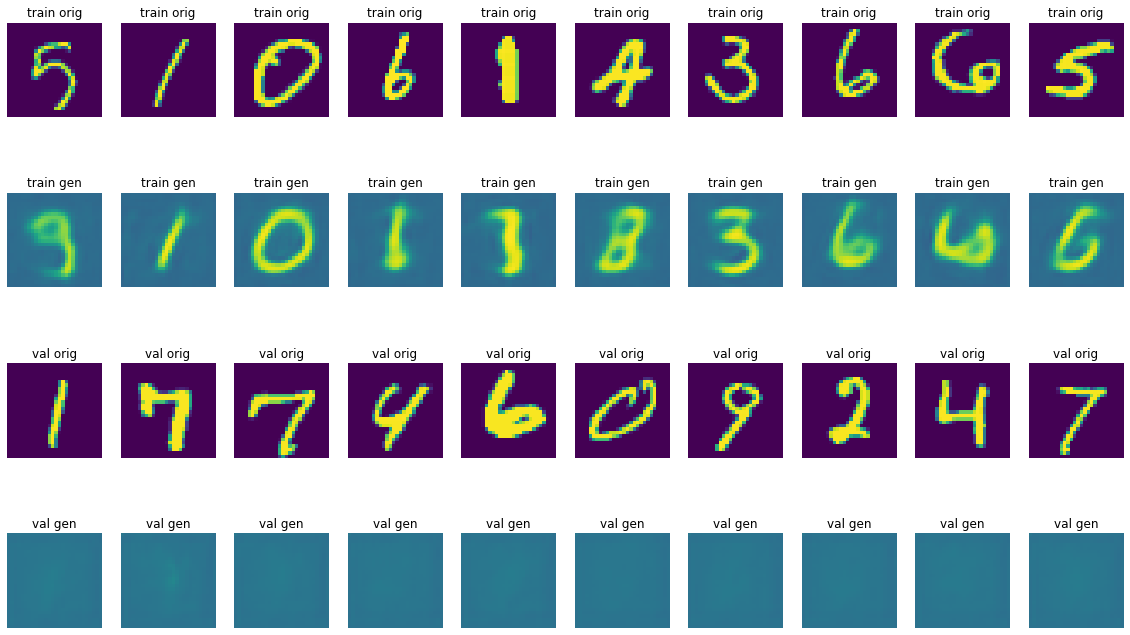

E: 0001 / B: 0004 - KL_Loss: 10.9126 - IMG_loss: 0.4986
                        val: 16.3306 -      val: 0.4963
	Gen_loss: 1.1123 - Disc_on_orig: 0.4369 - Disc_on_gen: 0.4193
	     val: 0.5847 -          val: 0.3171 -         val: 0.8193



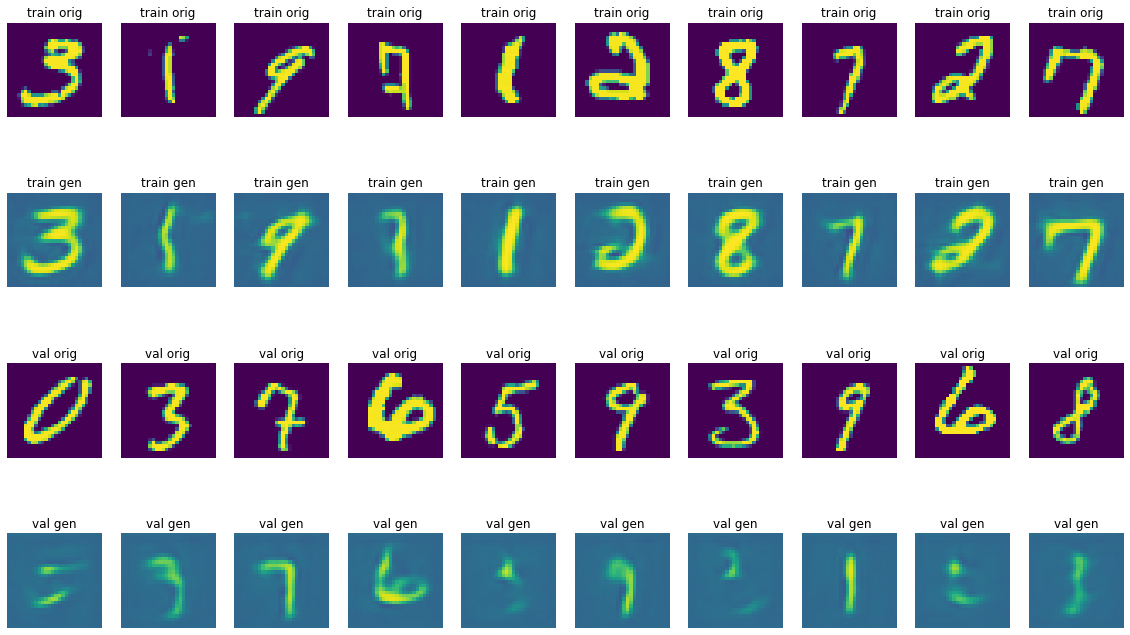

E: 0002 / B: 0004 - KL_Loss: 13.6830 - IMG_loss: 0.4573
                        val: 29.8807 -      val: 0.4970
	Gen_loss: 1.3312 - Disc_on_orig: 0.3688 - Disc_on_gen: 0.3460
	     val: 0.8503 -          val: 0.2898 -         val: 0.5713



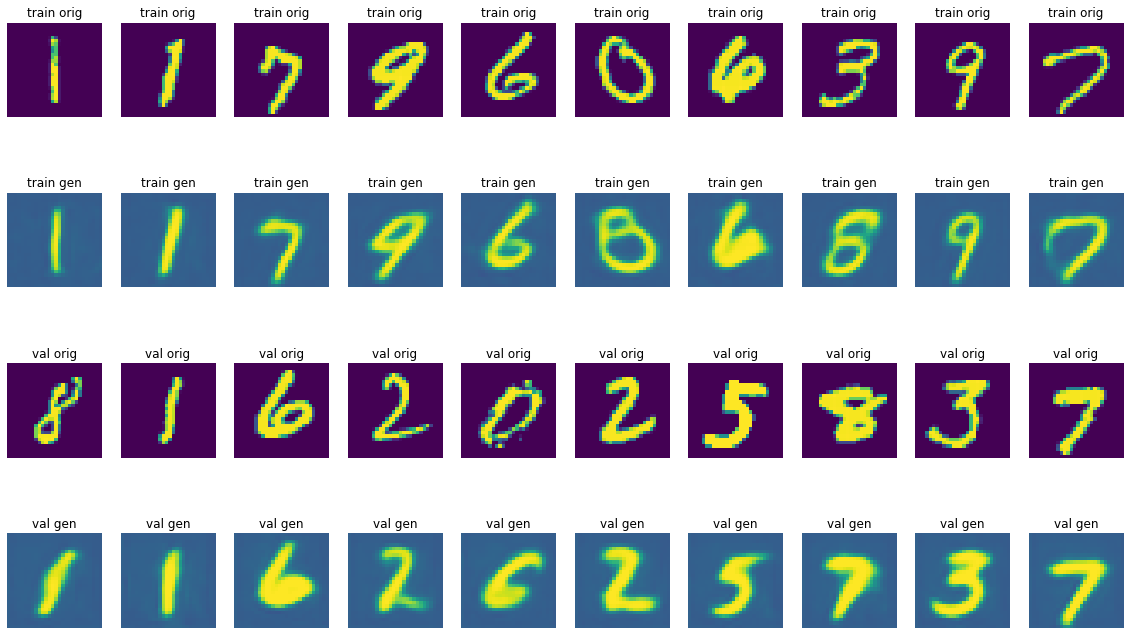

E: 0003 / B: 0004 - KL_Loss: 14.7928 - IMG_loss: 0.4245
                        val: 15.5737 -      val: 0.5397
	Gen_loss: 1.4961 - Disc_on_orig: 0.3262 - Disc_on_gen: 0.3229
	     val: 1.8652 -          val: 0.0561 -         val: 0.1782



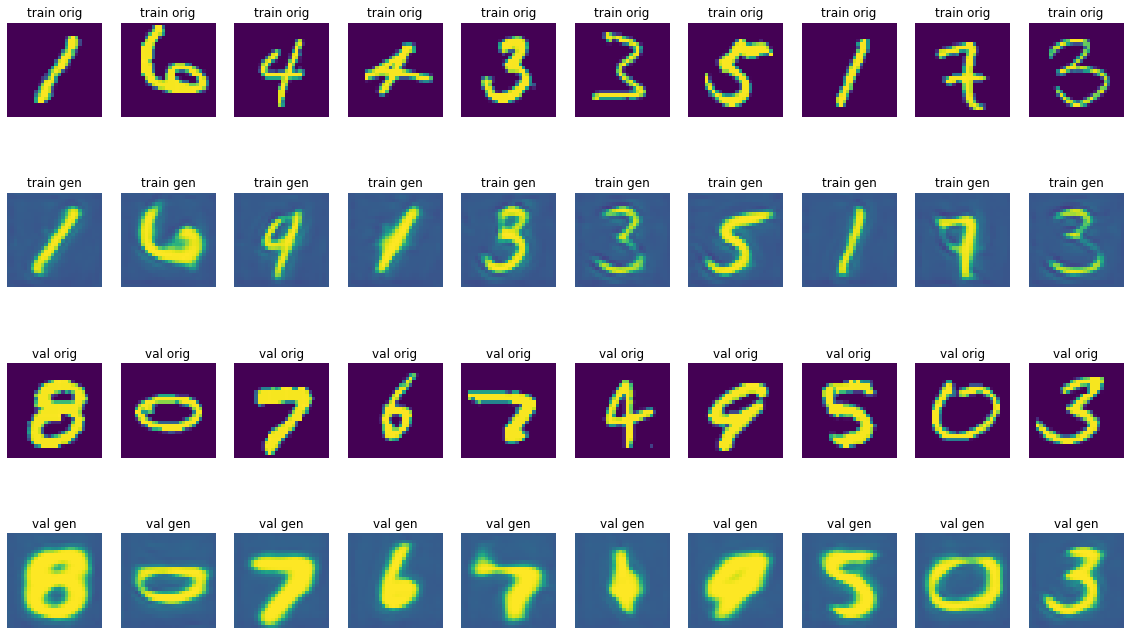

E: 0004 / B: 0004 - KL_Loss: 14.9790 - IMG_loss: 0.3930
                        val: 14.8506 -      val: 0.4169
	Gen_loss: 1.4184 - Disc_on_orig: 0.3775 - Disc_on_gen: 0.3577
	     val: 0.5246 -          val: 0.9838 -         val: 1.1387



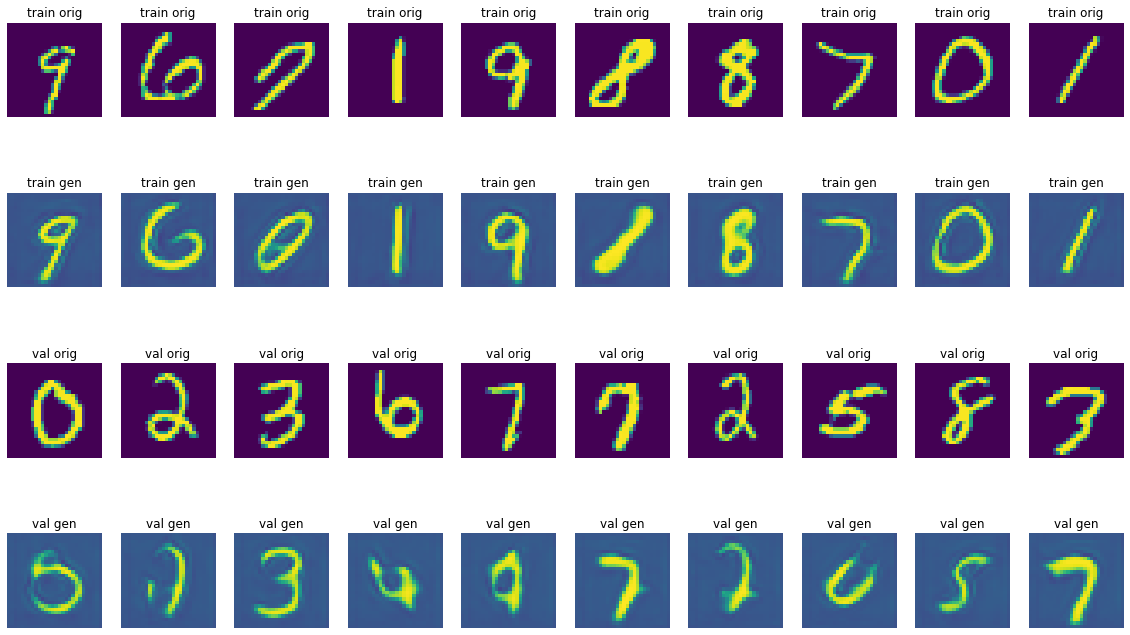

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_discrim/assets
E: 0005 / B: 0004 - KL_Loss: 16.1187 - IMG_loss: 0.3655
                        val: 16.1786 -      val: 0.3587
	Gen_loss: 2.0398 - Disc_on_orig: 0.2077 - Disc_on_gen: 0.1894
	     val: 0.5561 -          val: 0.9846 -         val: 1.0221



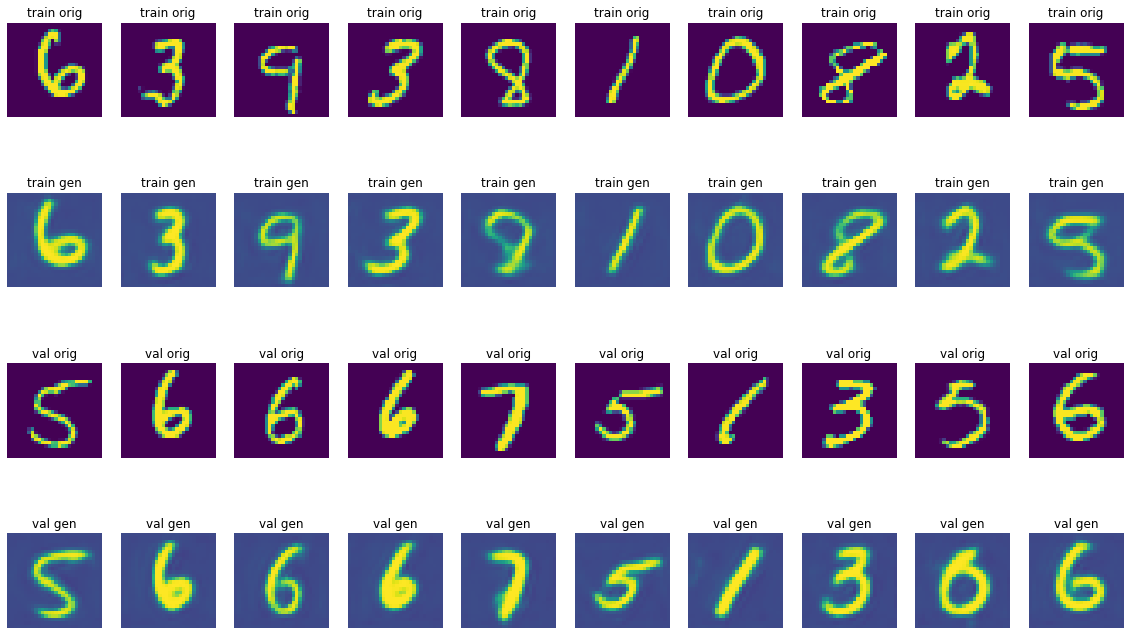

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0006 / B: 0004 - KL_Loss: 16.0317 - IMG_loss: 0.3416
                        val: 21.0086 -      val: 0.3622
	Gen_loss: 2.4846 - Disc_on_orig: 0.0890 - Disc_on_gen: 0.1040
	     val: 0.7706 -          val: 0.2029 -         val: 0.7277



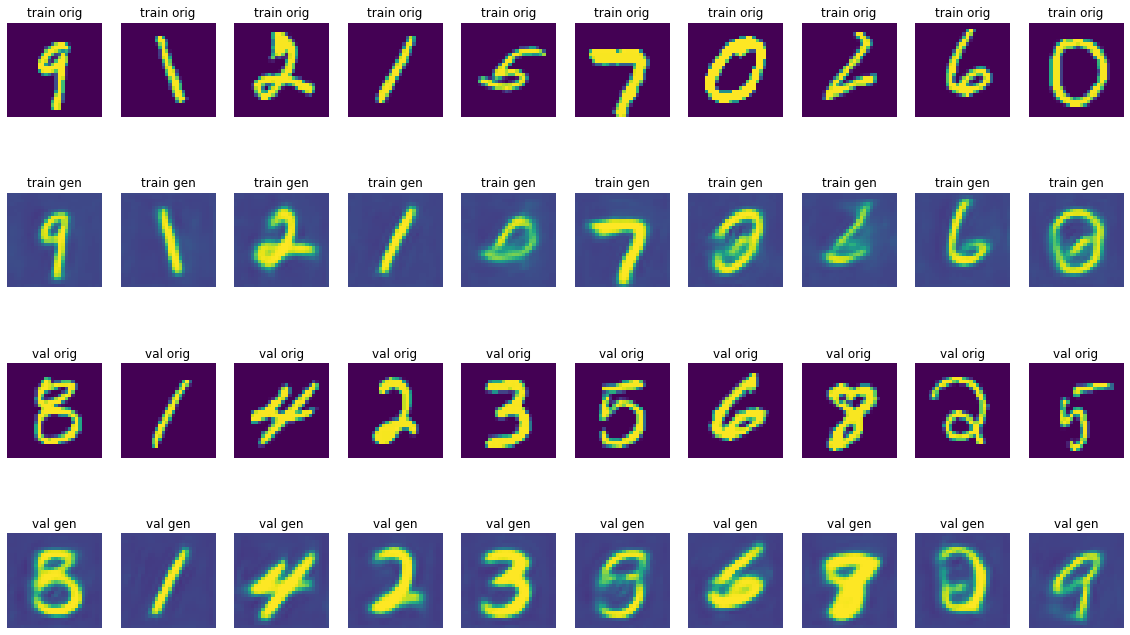

E: 0007 / B: 0004 - KL_Loss: 15.8685 - IMG_loss: 0.3294
                        val: 14.6837 -      val: 0.3203
	Gen_loss: 2.7106 - Disc_on_orig: 0.0901 - Disc_on_gen: 0.0867
	     val: 0.8381 -          val: 0.3209 -         val: 0.6323



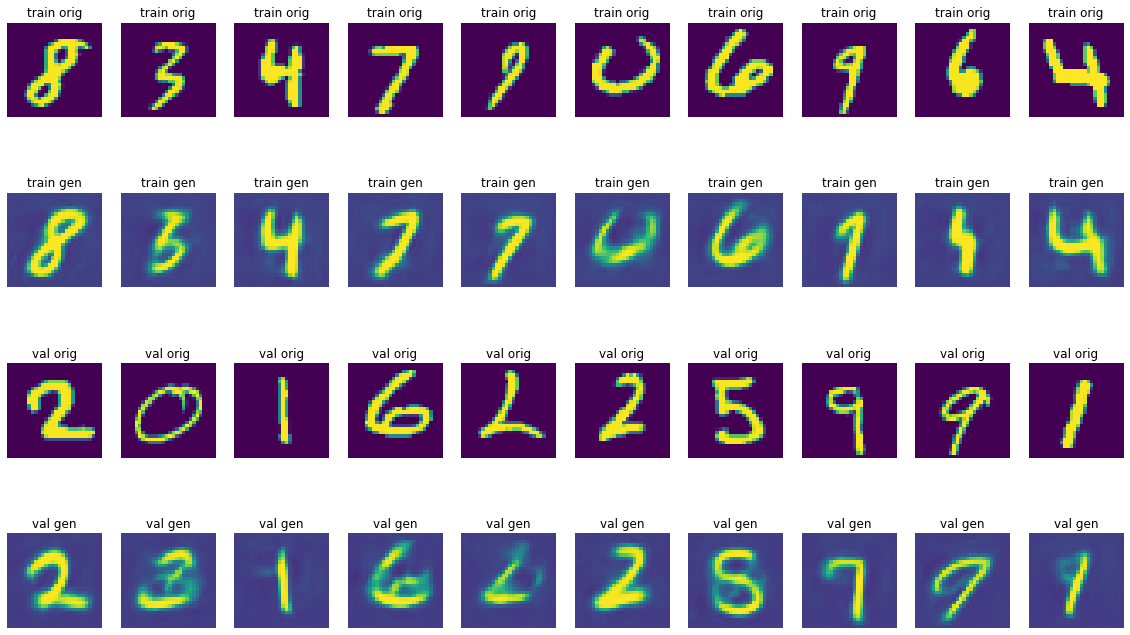

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0008 / B: 0004 - KL_Loss: 17.6045 - IMG_loss: 0.3211
                        val: 15.3329 -      val: 0.3273
	Gen_loss: 1.8111 - Disc_on_orig: 0.3811 - Disc_on_gen: 0.3713
	     val: 0.8328 -          val: 0.5777 -         val: 0.7631



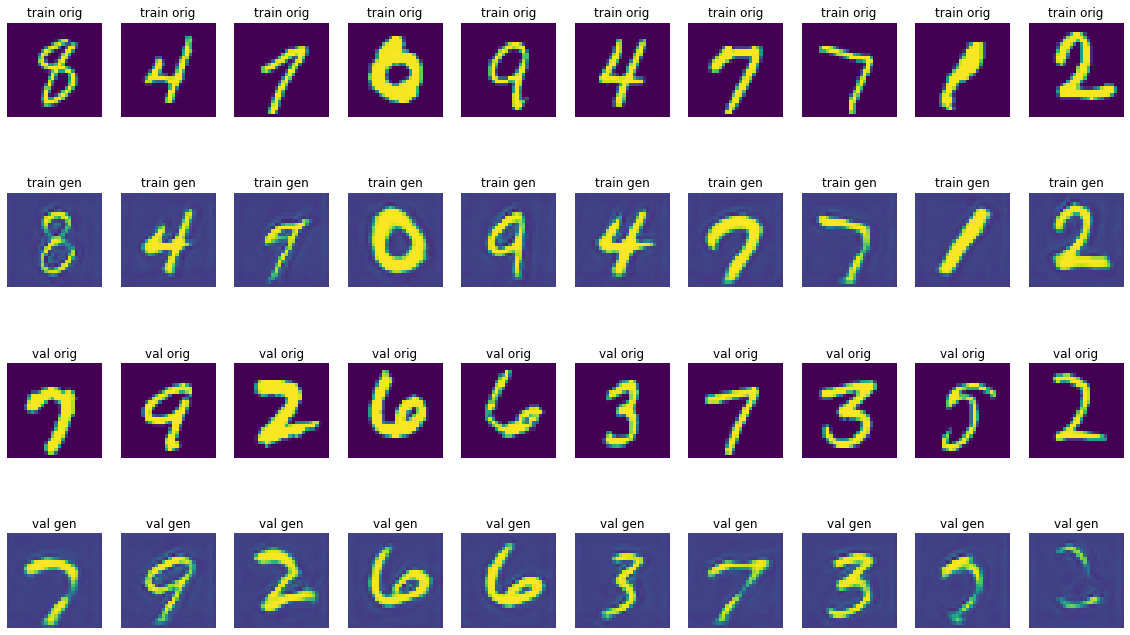

E: 0009 / B: 0004 - KL_Loss: 20.1597 - IMG_loss: 0.3109
                        val: 42.8326 -      val: 0.4748
	Gen_loss: 1.6393 - Disc_on_orig: 0.4101 - Disc_on_gen: 0.4381
	     val: 1.1513 -          val: 0.3846 -         val: 0.5044



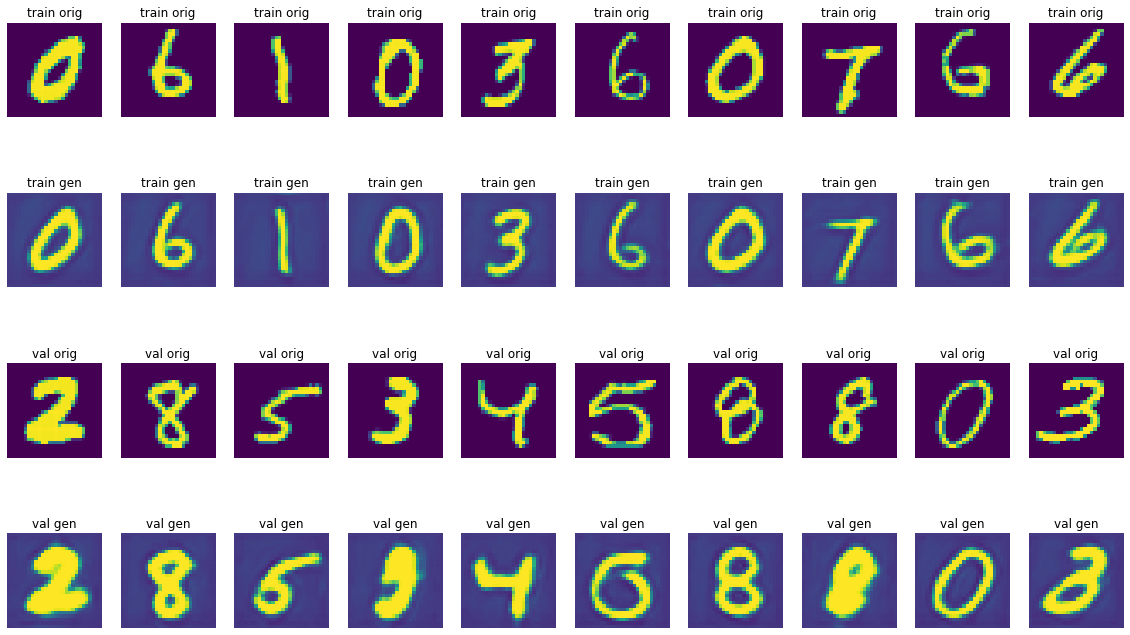

E: 0010 / B: 0004 - KL_Loss: 21.0918 - IMG_loss: 0.3010
                        val: 30.5551 -      val: 0.8260
	Gen_loss: 1.7060 - Disc_on_orig: 0.3800 - Disc_on_gen: 0.4050
	     val: 1.3140 -          val: 1.0762 -         val: 6.6104



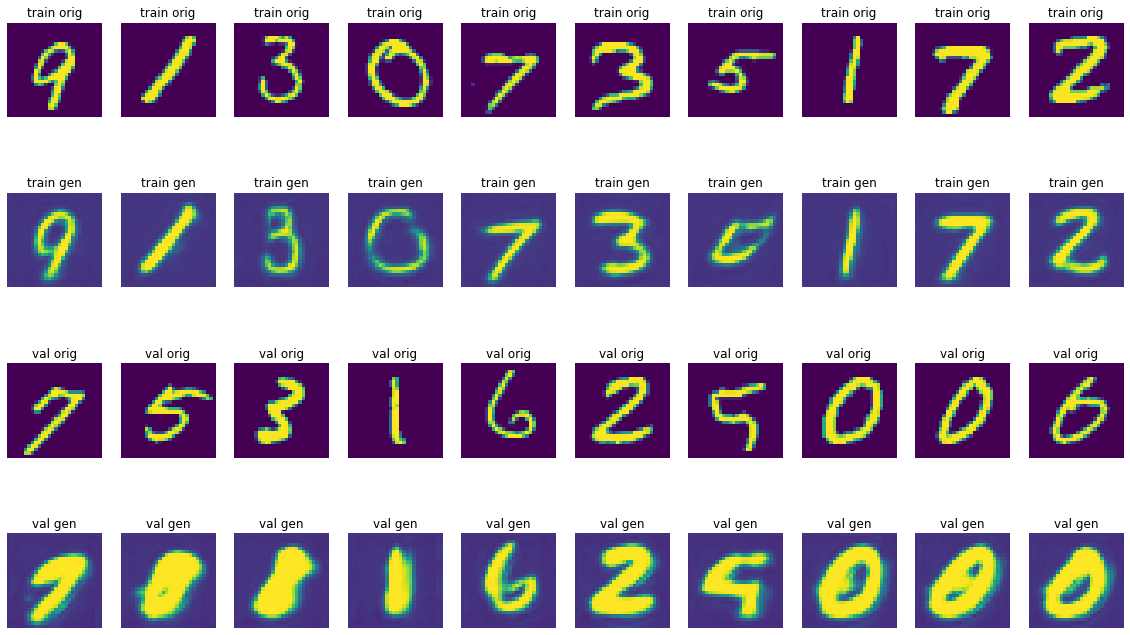

E: 0011 / B: 0004 - KL_Loss: 22.3347 - IMG_loss: 0.3043
                        val: 34.1790 -      val: 0.6190
	Gen_loss: 1.3109 - Disc_on_orig: 0.4738 - Disc_on_gen: 0.4504
	     val: 3.1510 -          val: 0.8818 -         val: 0.1859



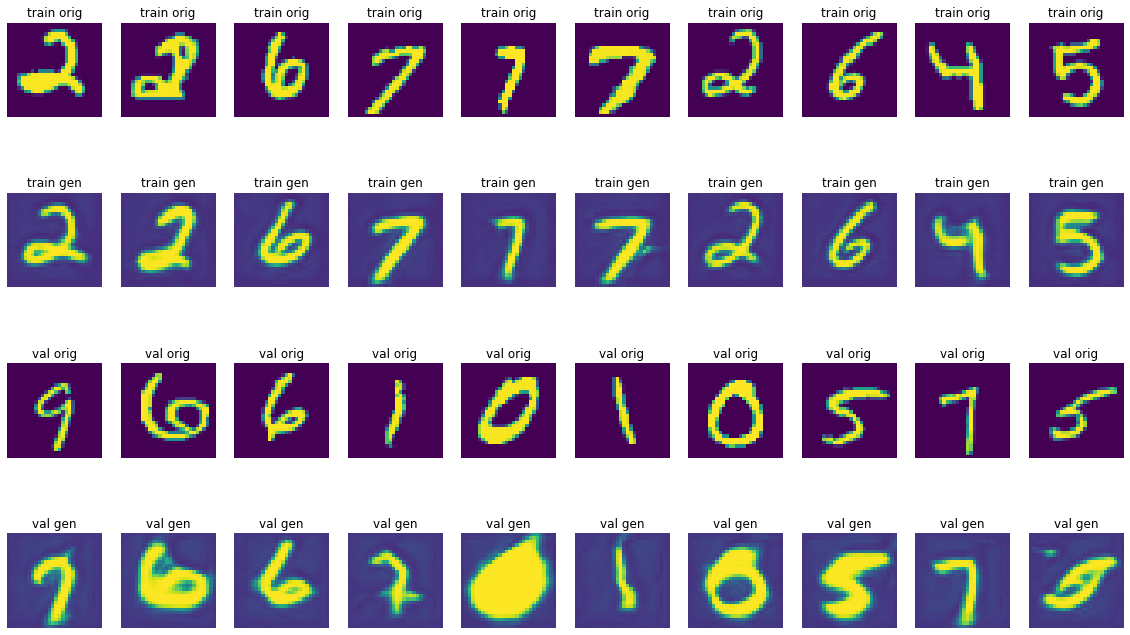

E: 0012 / B: 0004 - KL_Loss: 21.0075 - IMG_loss: 0.2792
                        val: 31.7196 -      val: 0.3221
	Gen_loss: 1.4776 - Disc_on_orig: 0.4564 - Disc_on_gen: 0.4564
	     val: 0.0218 -          val: 0.8900 -         val: 8.5476



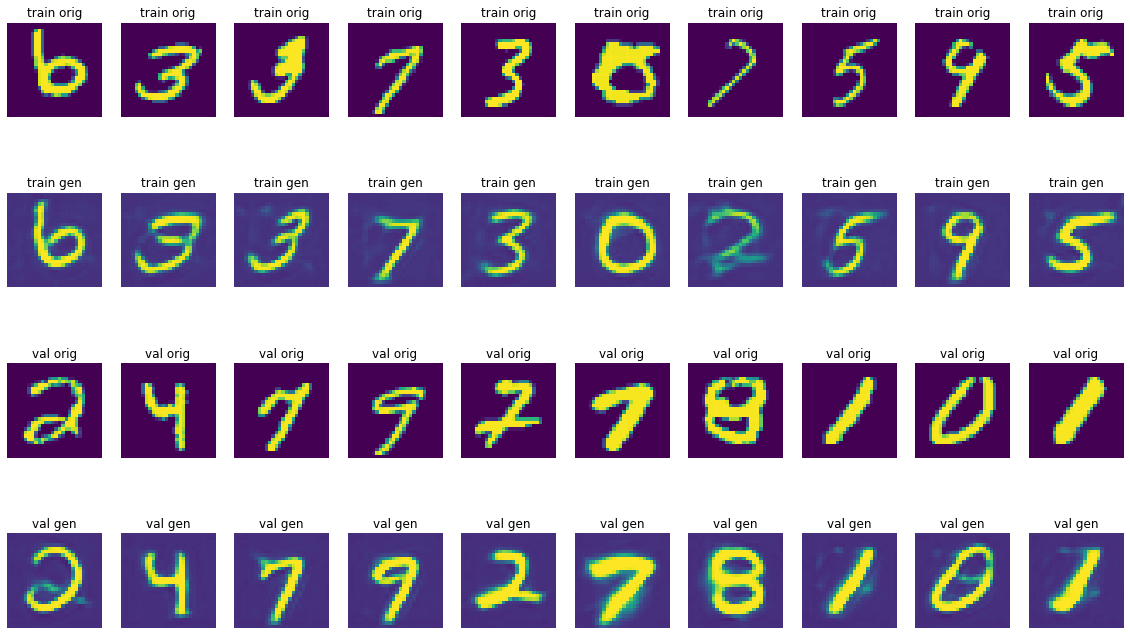

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_discrim/assets
E: 0013 / B: 0004 - KL_Loss: 20.8163 - IMG_loss: 0.2699
                        val: 24.2989 -      val: 0.2956
	Gen_loss: 1.8137 - Disc_on_orig: 0.3380 - Disc_on_gen: 0.3218
	     val: 0.7972 -          val: 0.5109 -         val: 0.8911



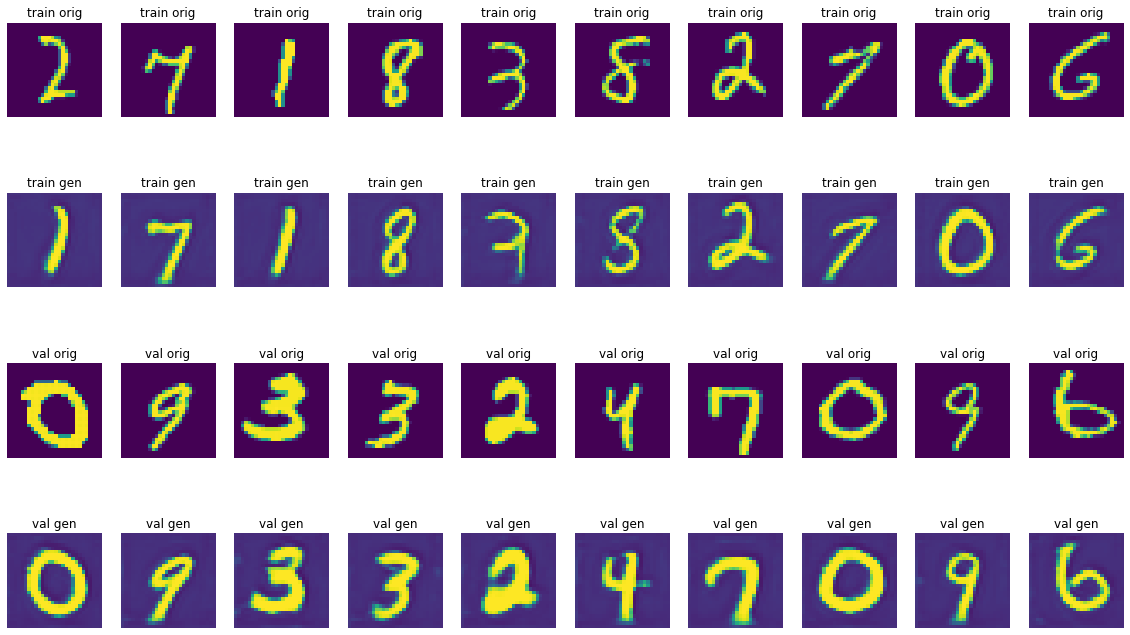

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0014 / B: 0004 - KL_Loss: 20.3081 - IMG_loss: 0.2599
                        val: 19.4512 -      val: 0.3600
	Gen_loss: 1.3646 - Disc_on_orig: 0.4702 - Disc_on_gen: 0.5477
	     val: 0.9341 -          val: 0.8921 -         val: 1.3766



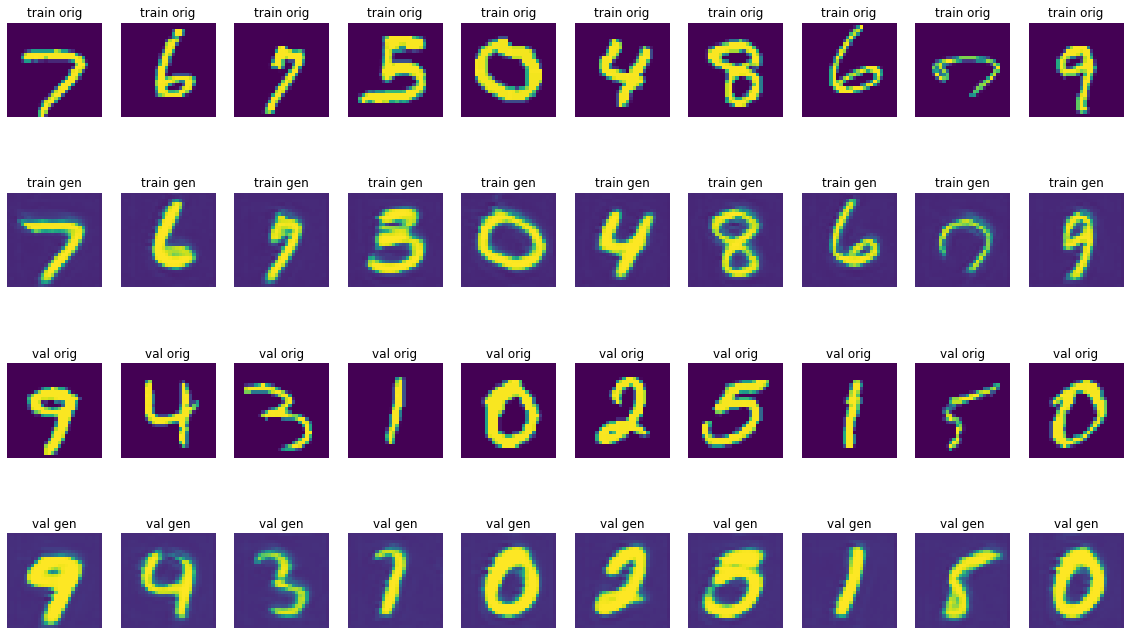

E: 0015 / B: 0004 - KL_Loss: 22.6262 - IMG_loss: 0.2582
                        val: 28.6896 -      val: 0.3384
	Gen_loss: 1.7872 - Disc_on_orig: 0.3987 - Disc_on_gen: 0.3915
	     val: 0.5115 -          val: 0.3515 -         val: 1.4426



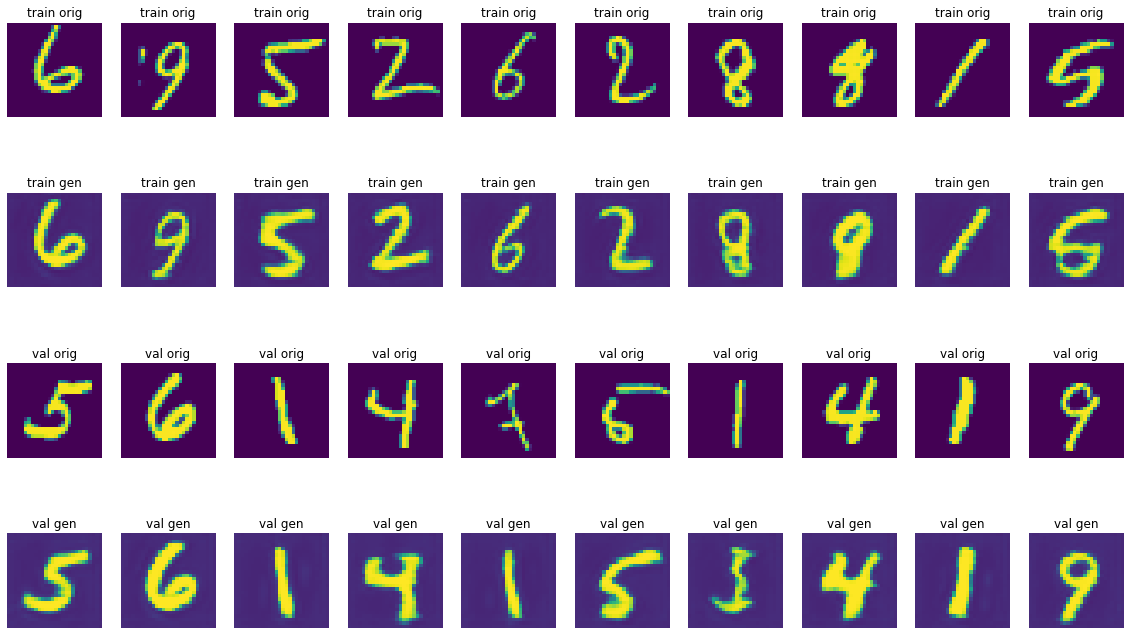

E: 0016 / B: 0004 - KL_Loss: 22.4033 - IMG_loss: 0.2480
                        val: 25.5446 -      val: 0.3160
	Gen_loss: 1.8302 - Disc_on_orig: 0.3735 - Disc_on_gen: 0.3710
	     val: 1.1596 -          val: 0.4277 -         val: 0.7050



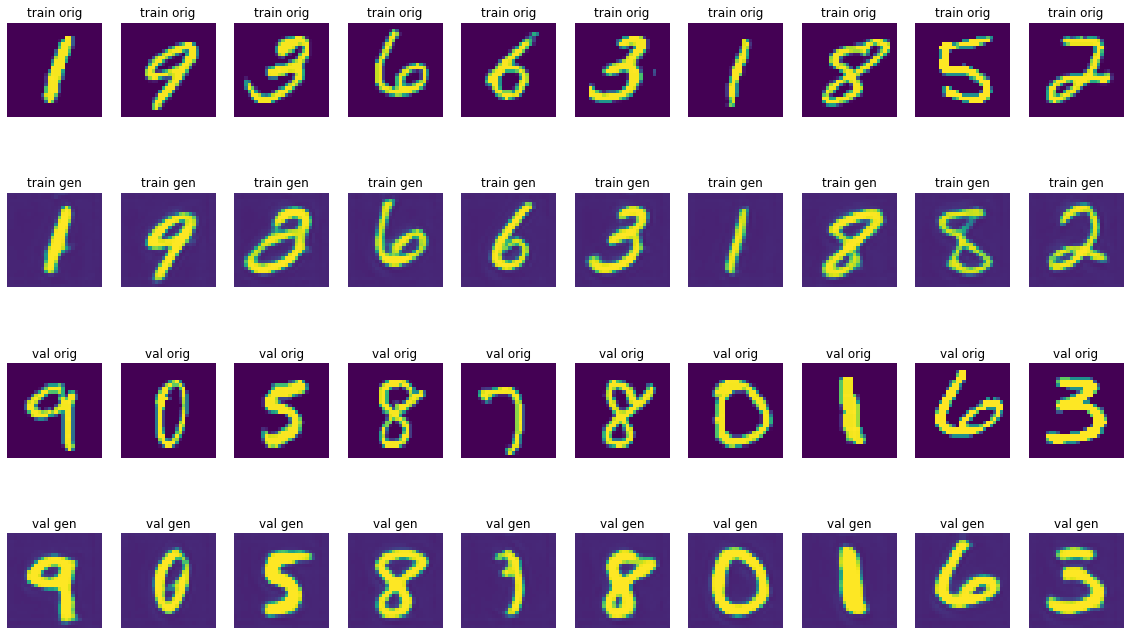

E: 0017 / B: 0004 - KL_Loss: 21.5574 - IMG_loss: 0.2422
                        val: 21.3650 -      val: 0.2862
	Gen_loss: 1.7094 - Disc_on_orig: 0.3911 - Disc_on_gen: 0.3971
	     val: 1.0174 -          val: 0.1555 -         val: 0.9838



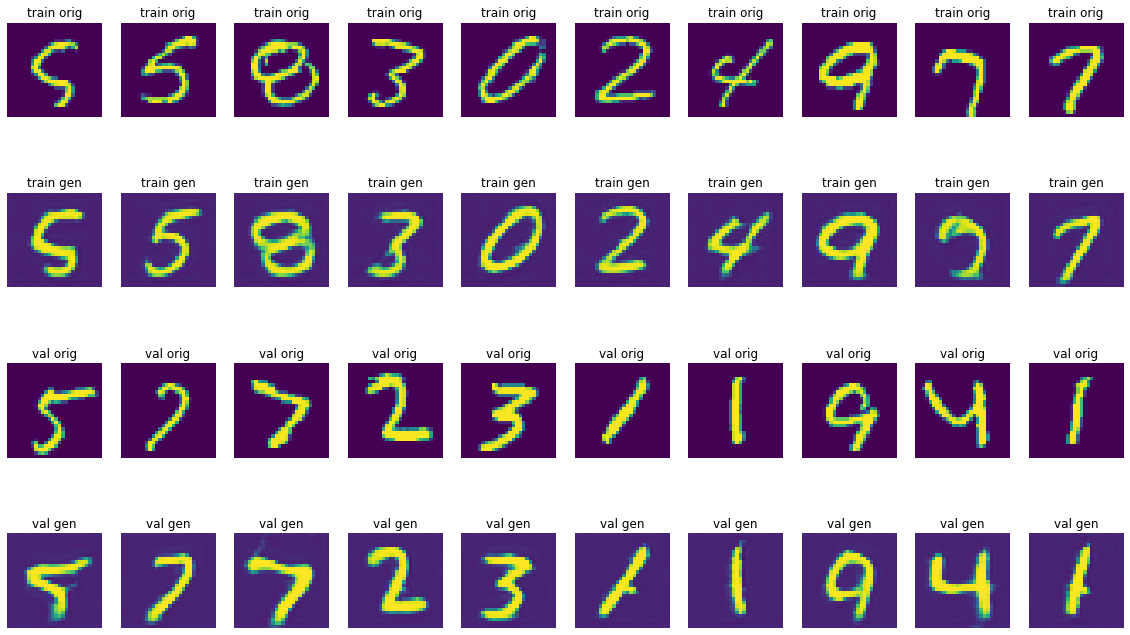

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0018 / B: 0004 - KL_Loss: 20.9959 - IMG_loss: 0.2251
                        val: 40.2653 -      val: 0.3310
	Gen_loss: 1.0694 - Disc_on_orig: 0.6124 - Disc_on_gen: 0.7054
	     val: 0.9398 -          val: 1.1287 -         val: 0.8039



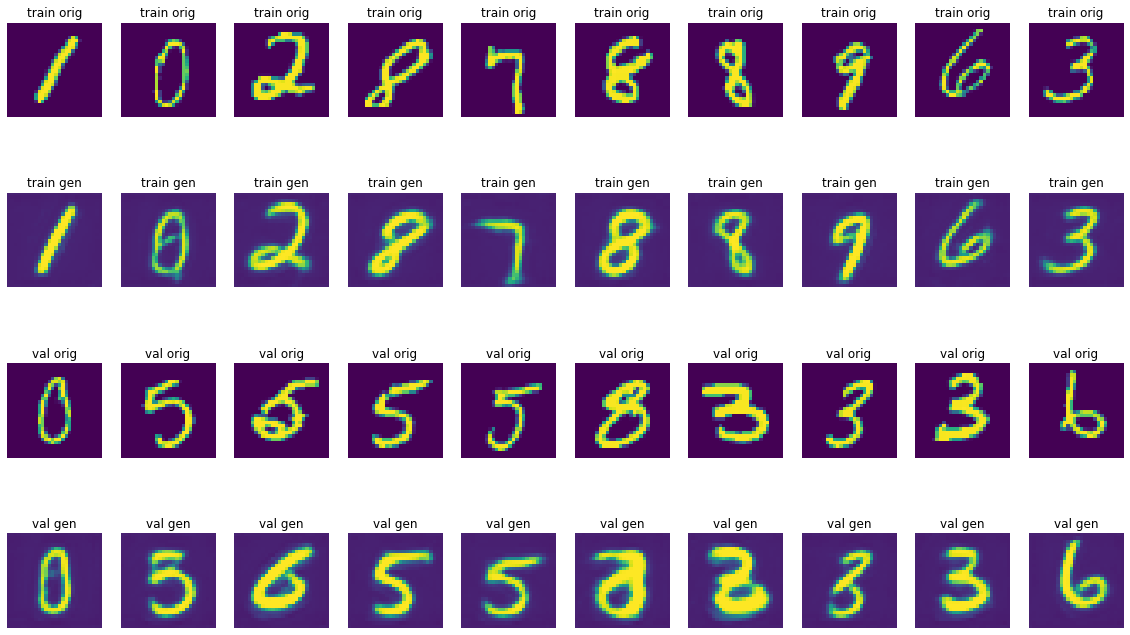

E: 0019 / B: 0004 - KL_Loss: 21.7121 - IMG_loss: 0.2316
                        val: 32.0286 -      val: 0.2704
	Gen_loss: 0.9922 - Disc_on_orig: 0.5754 - Disc_on_gen: 0.5661
	     val: 0.2971 -          val: 0.1085 -         val: 2.2083



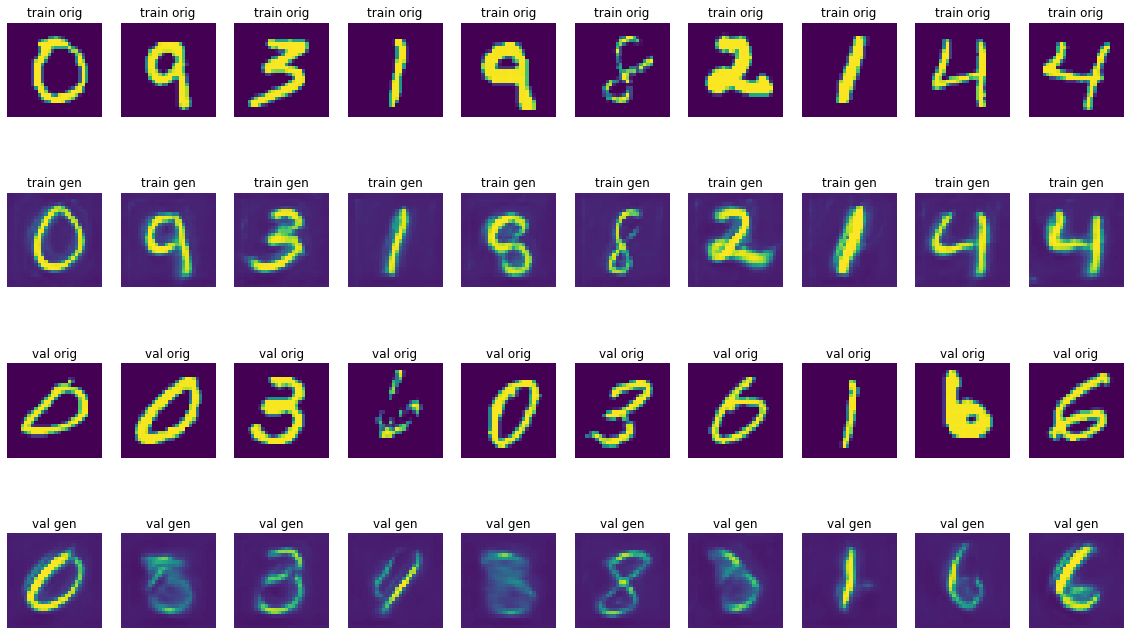

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0020 / B: 0004 - KL_Loss: 25.2494 - IMG_loss: 0.2401
                        val: 46.5960 -      val: 0.3672
	Gen_loss: 1.2532 - Disc_on_orig: 0.5034 - Disc_on_gen: 0.4881
	     val: 0.5822 -          val: 0.4136 -         val: 0.9692



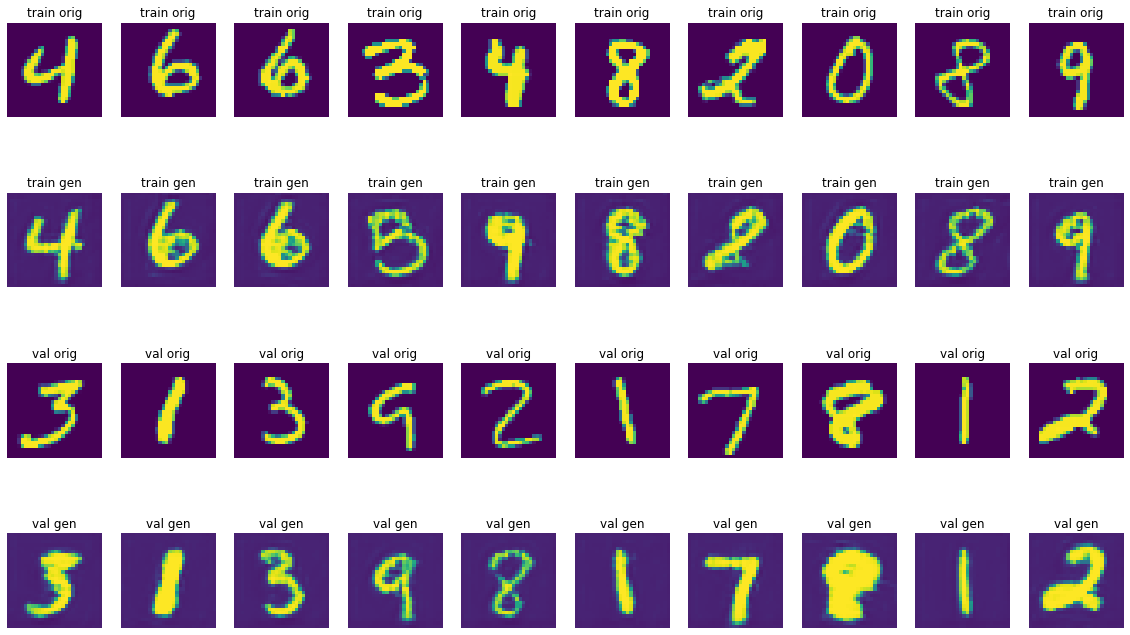

E: 0021 / B: 0004 - KL_Loss: 23.7948 - IMG_loss: 0.2204
                        val: 33.9316 -      val: 0.2825
	Gen_loss: 1.7321 - Disc_on_orig: 0.2853 - Disc_on_gen: 0.3183
	     val: 0.6637 -          val: 1.1279 -         val: 0.9242



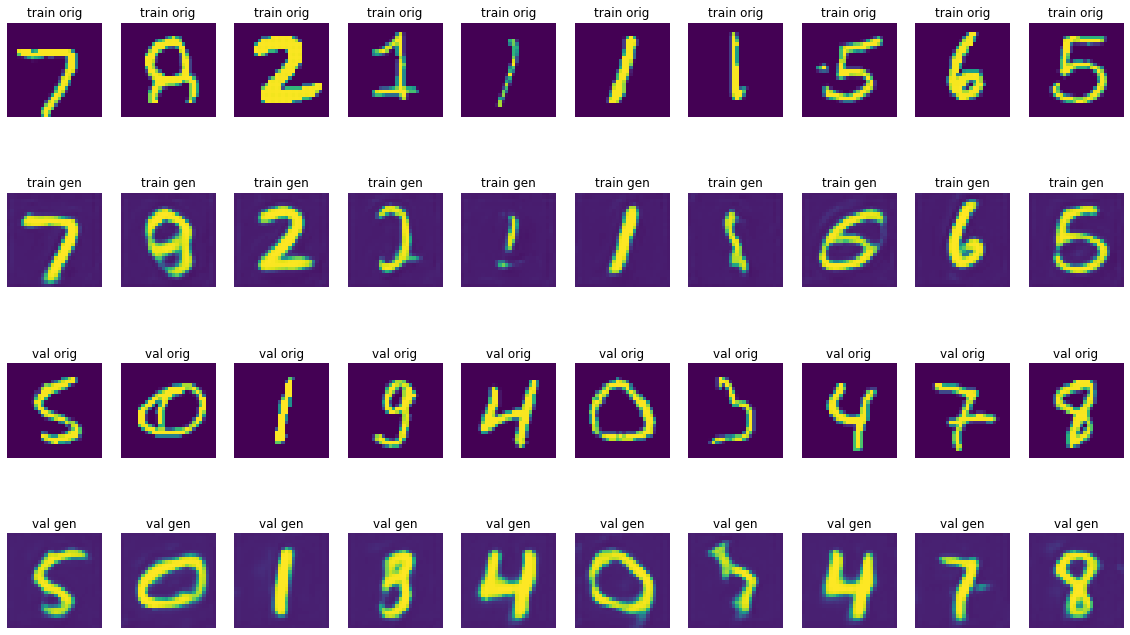

E: 0022 / B: 0004 - KL_Loss: 25.0756 - IMG_loss: 0.2241
                        val: 28.4142 -      val: 0.2780
	Gen_loss: 1.5703 - Disc_on_orig: 0.4481 - Disc_on_gen: 0.4187
	     val: 0.7868 -          val: 0.6924 -         val: 0.8355



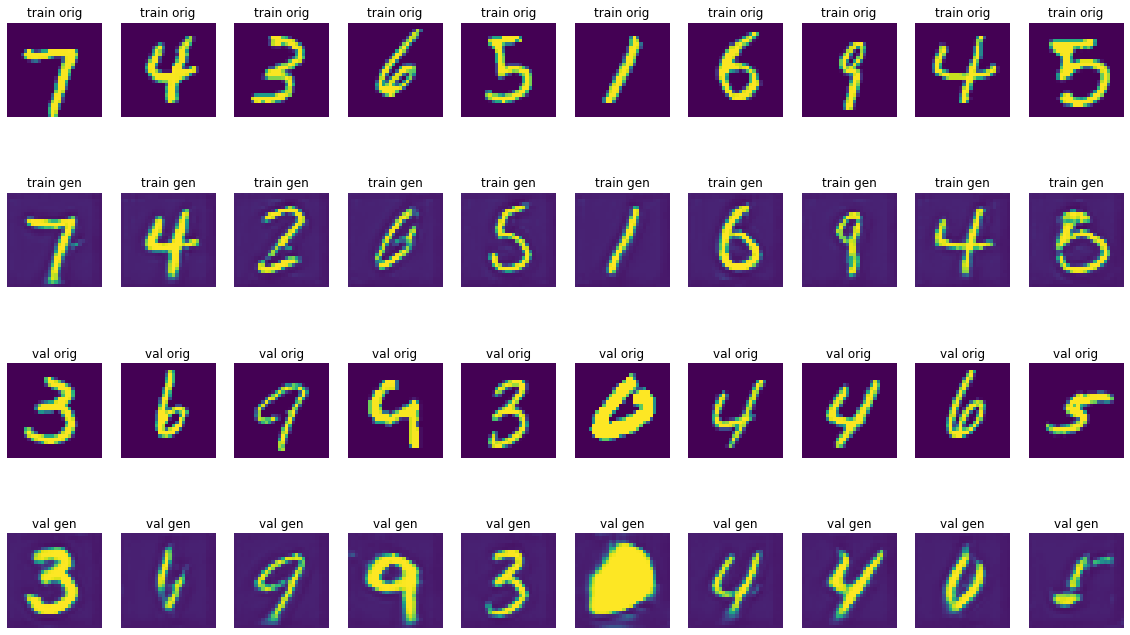

E: 0023 / B: 0004 - KL_Loss: 23.9124 - IMG_loss: 0.2151
                        val: 28.3002 -      val: 0.3166
	Gen_loss: 1.3385 - Disc_on_orig: 0.5204 - Disc_on_gen: 0.5915
	     val: 0.2312 -          val: 0.1635 -         val: 3.6712



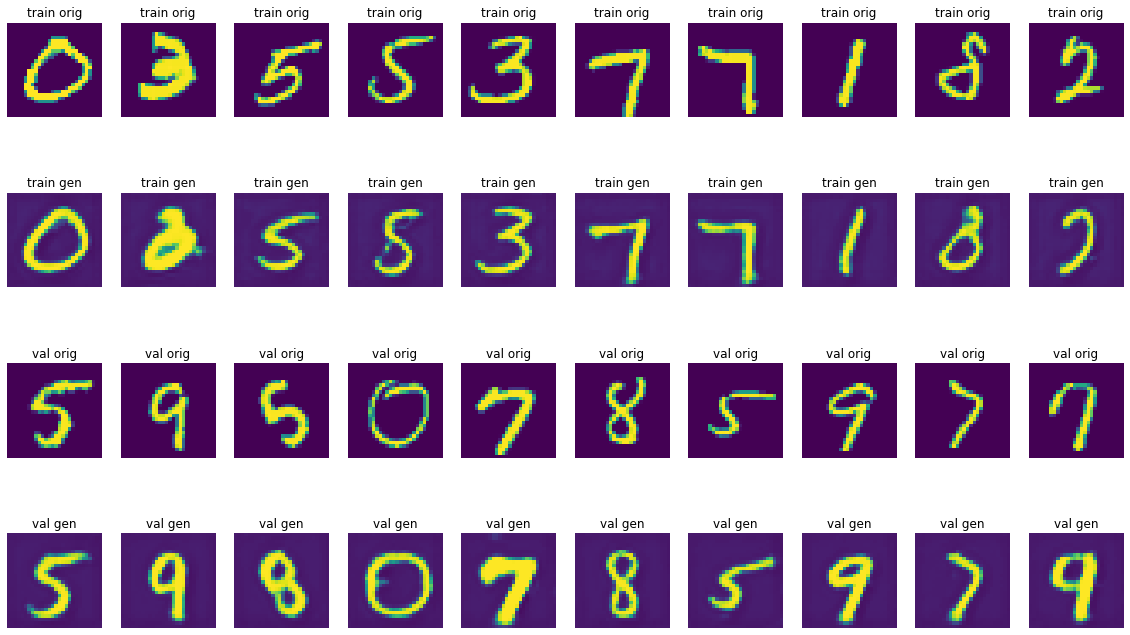

E: 0024 / B: 0004 - KL_Loss: 23.8061 - IMG_loss: 0.2088
                        val: 27.9899 -      val: 0.2049
	Gen_loss: 1.3499 - Disc_on_orig: 0.5293 - Disc_on_gen: 0.4792
	     val: 0.7244 -          val: 0.7049 -         val: 0.8039



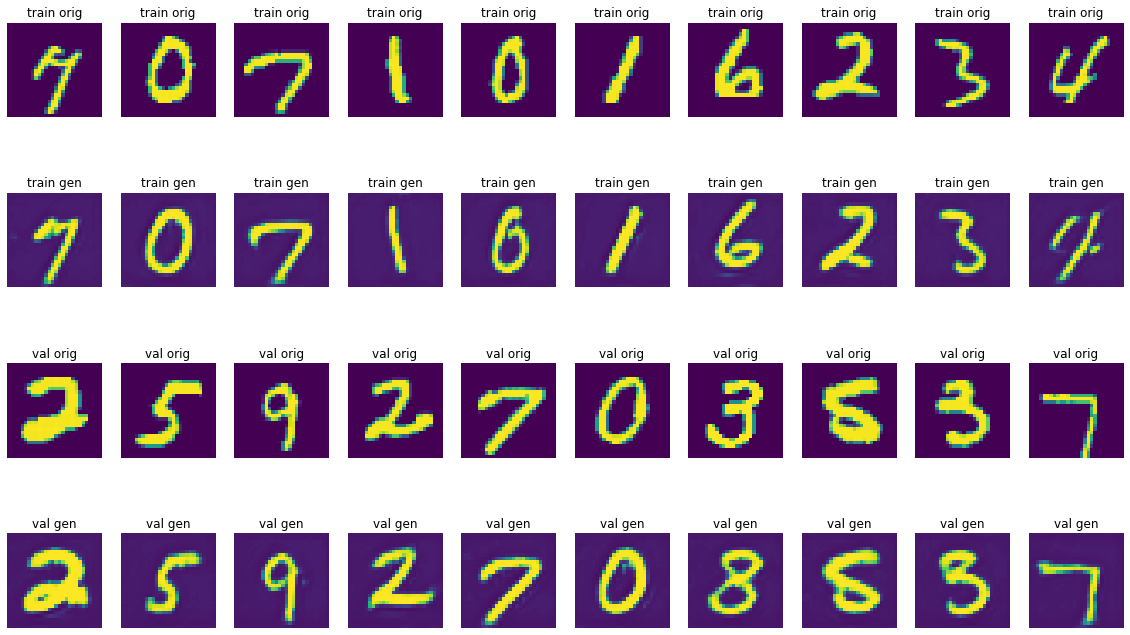

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0025 / B: 0004 - KL_Loss: 23.5493 - IMG_loss: 0.2026
                        val: 24.2755 -      val: 0.2271
	Gen_loss: 1.2027 - Disc_on_orig: 0.5224 - Disc_on_gen: 0.5924
	     val: 1.3295 -          val: 1.1087 -         val: 0.7586



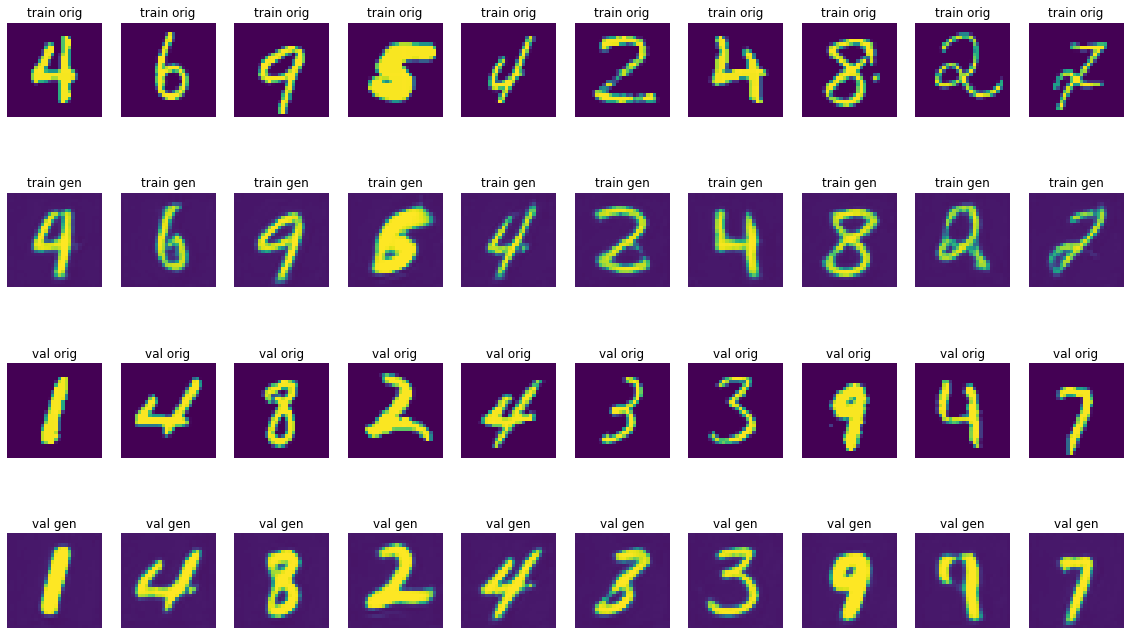

E: 0026 / B: 0004 - KL_Loss: 23.5344 - IMG_loss: 0.2004
                        val: 21.8230 -      val: 0.2174
	Gen_loss: 1.1875 - Disc_on_orig: 0.5308 - Disc_on_gen: 0.5594
	     val: 3.4865 -          val: 0.6381 -         val: 0.1117



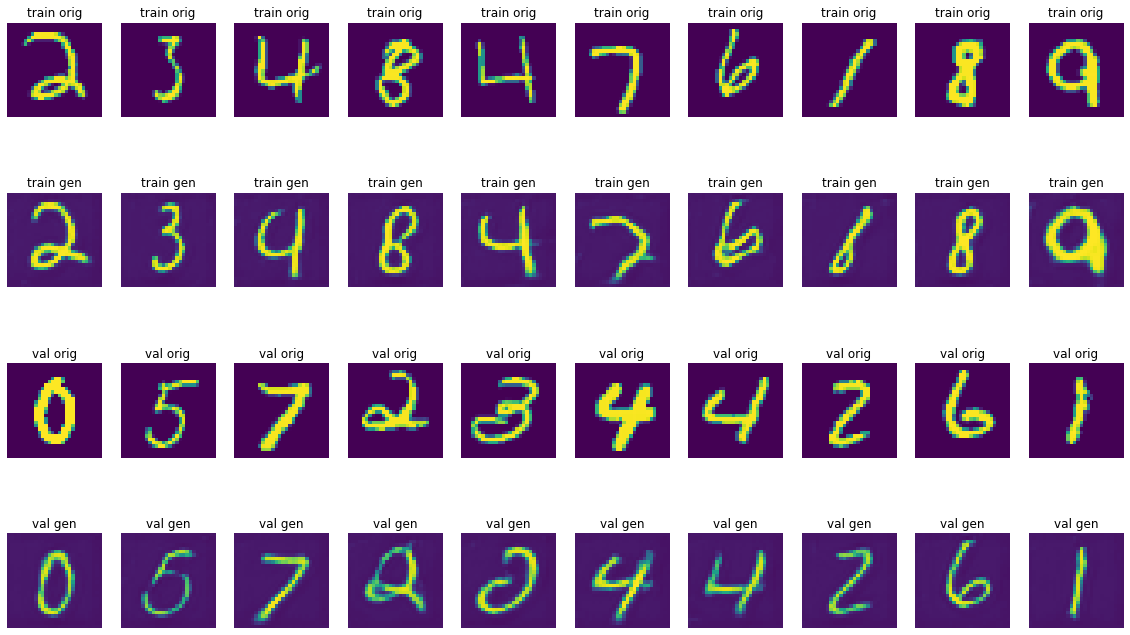

E: 0027 / B: 0004 - KL_Loss: 26.1846 - IMG_loss: 0.2124
                        val: 23.5741 -      val: 0.2077
	Gen_loss: 1.3142 - Disc_on_orig: 0.5374 - Disc_on_gen: 0.5648
	     val: 1.0803 -          val: 0.6715 -         val: 0.5980



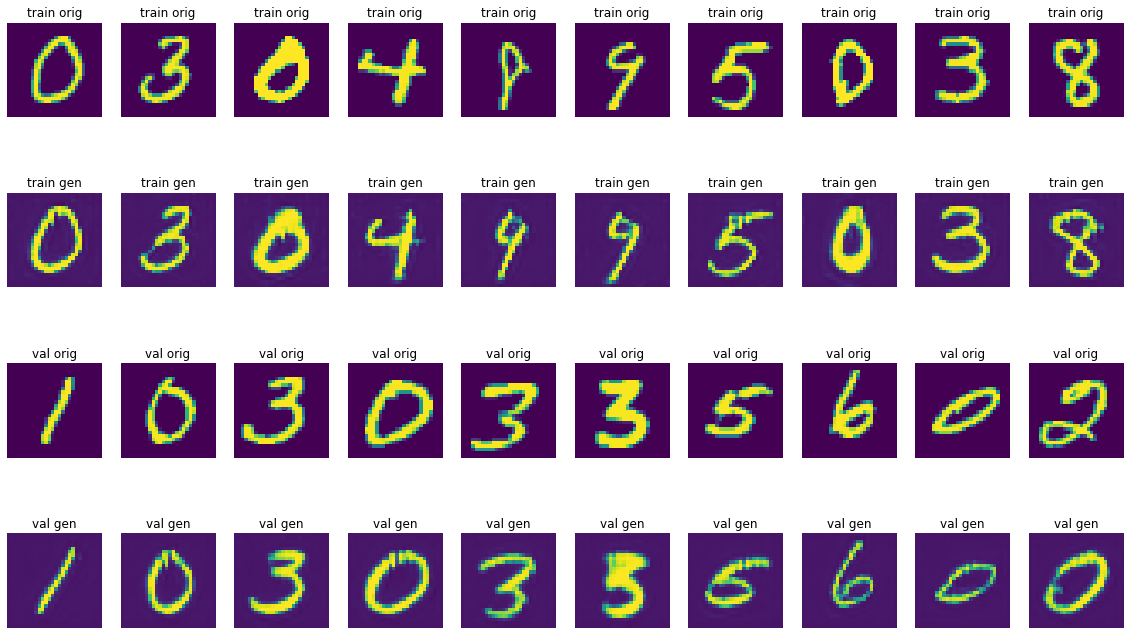

E: 0028 / B: 0004 - KL_Loss: 24.6025 - IMG_loss: 0.2038
                        val: 35.3874 -      val: 0.2735
	Gen_loss: 1.2033 - Disc_on_orig: 0.5206 - Disc_on_gen: 0.6526
	     val: 0.4759 -          val: 0.5051 -         val: 1.4276



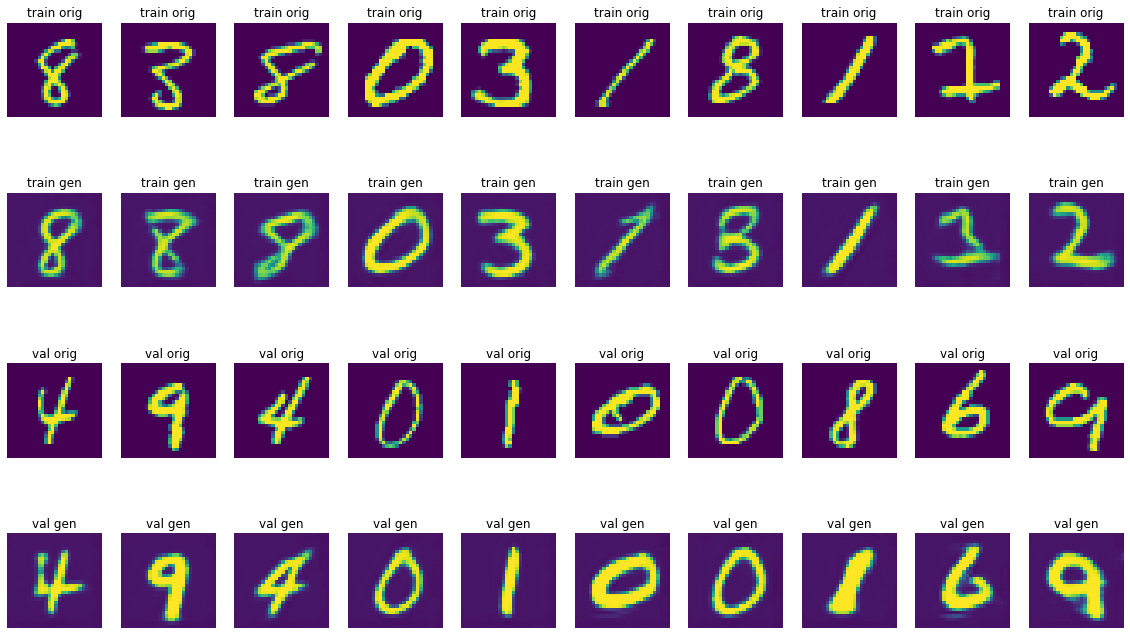

E: 0029 / B: 0004 - KL_Loss: 23.4076 - IMG_loss: 0.1944
                        val: 31.8452 -      val: 0.3196
	Gen_loss: 1.3106 - Disc_on_orig: 0.5384 - Disc_on_gen: 0.5511
	     val: 1.6114 -          val: 0.8934 -         val: 0.6057



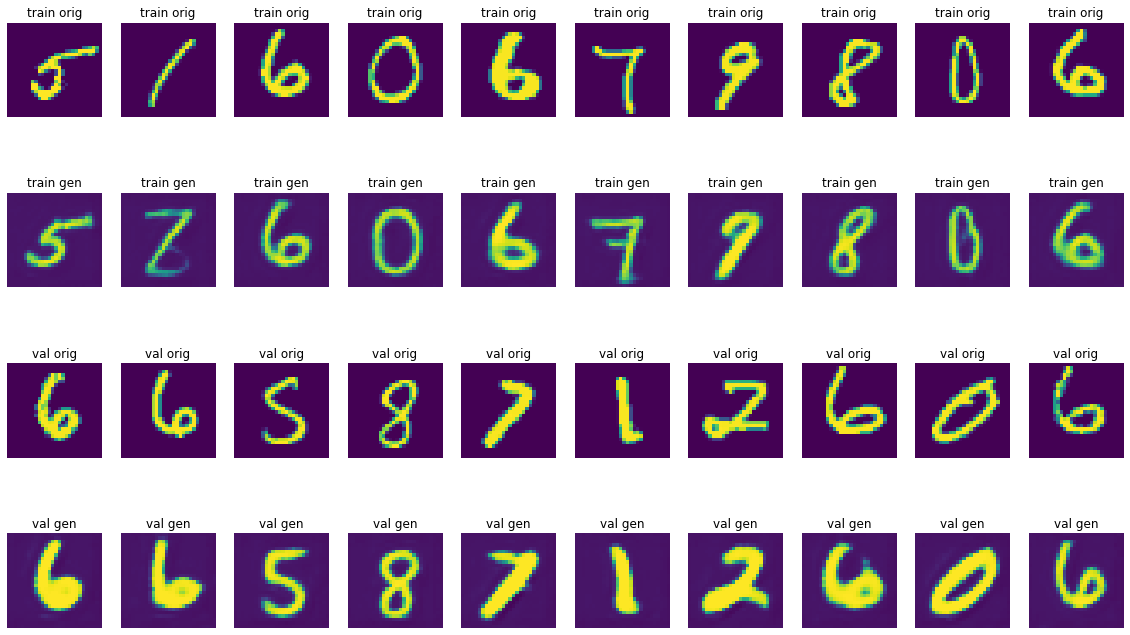

E: 0030 / B: 0004 - KL_Loss: 23.9036 - IMG_loss: 0.1981
                        val: 27.8191 -      val: 0.1889
	Gen_loss: 1.4230 - Disc_on_orig: 0.4642 - Disc_on_gen: 0.4803
	     val: 2.1324 -          val: 0.5063 -         val: 0.2936



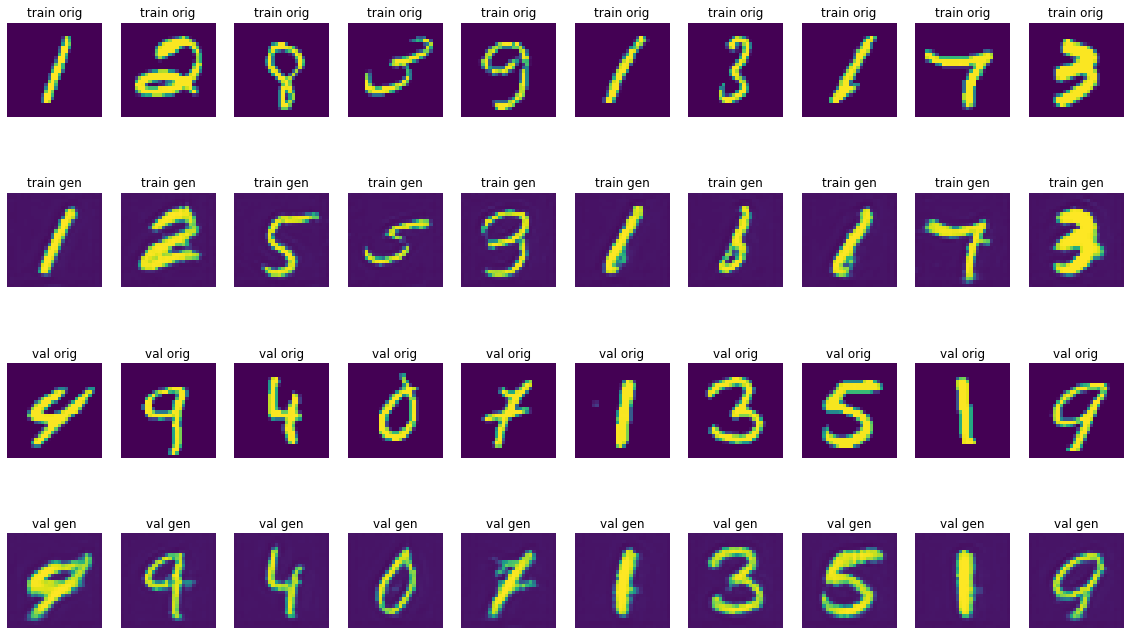

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0031 / B: 0004 - KL_Loss: 23.2112 - IMG_loss: 0.1875
                        val: 22.8757 -      val: 0.1815
	Gen_loss: 1.2472 - Disc_on_orig: 0.5502 - Disc_on_gen: 0.5981
	     val: 0.9284 -          val: 0.8083 -         val: 0.5996



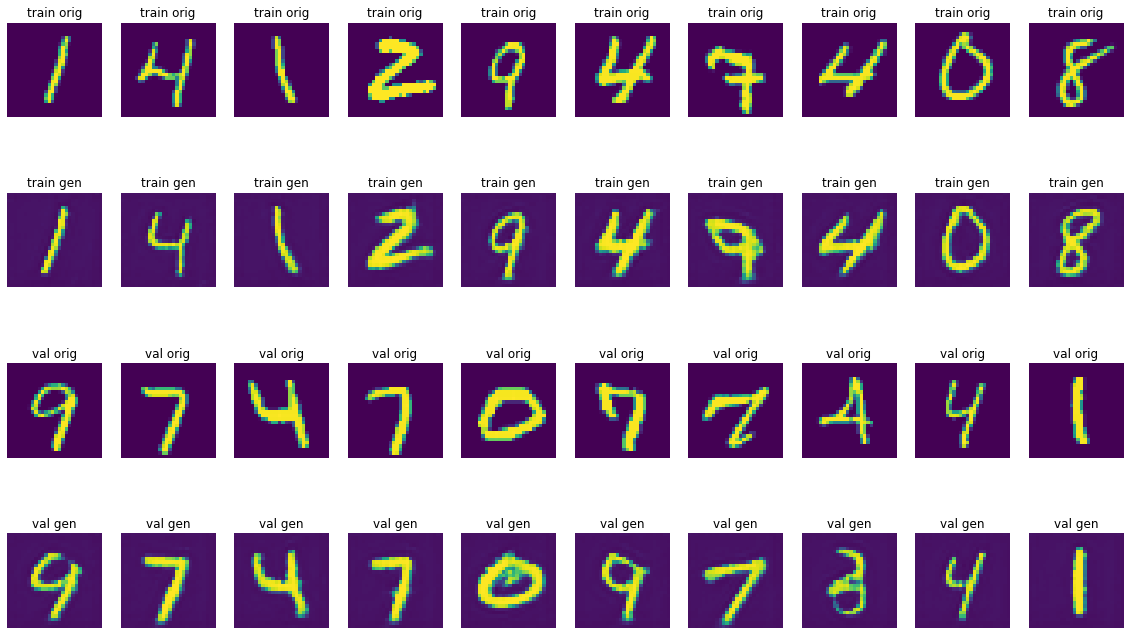

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0032 / B: 0004 - KL_Loss: 24.3113 - IMG_loss: 0.1887
                        val: 27.4654 -      val: 0.1867
	Gen_loss: 1.3010 - Disc_on_orig: 0.5335 - Disc_on_gen: 0.5677
	     val: 0.7019 -          val: 0.5772 -         val: 0.7602



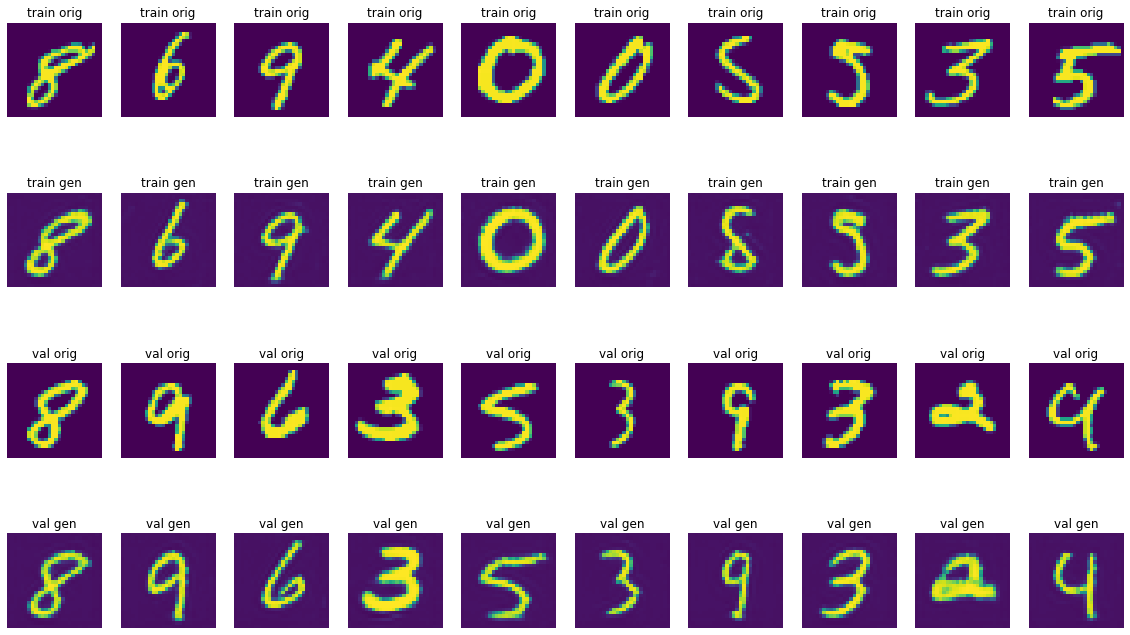

E: 0033 / B: 0004 - KL_Loss: 25.3591 - IMG_loss: 0.1878
                        val: 29.6091 -      val: 0.1890
	Gen_loss: 1.2569 - Disc_on_orig: 0.5277 - Disc_on_gen: 0.5259
	     val: 0.7375 -          val: 0.6730 -         val: 0.8050



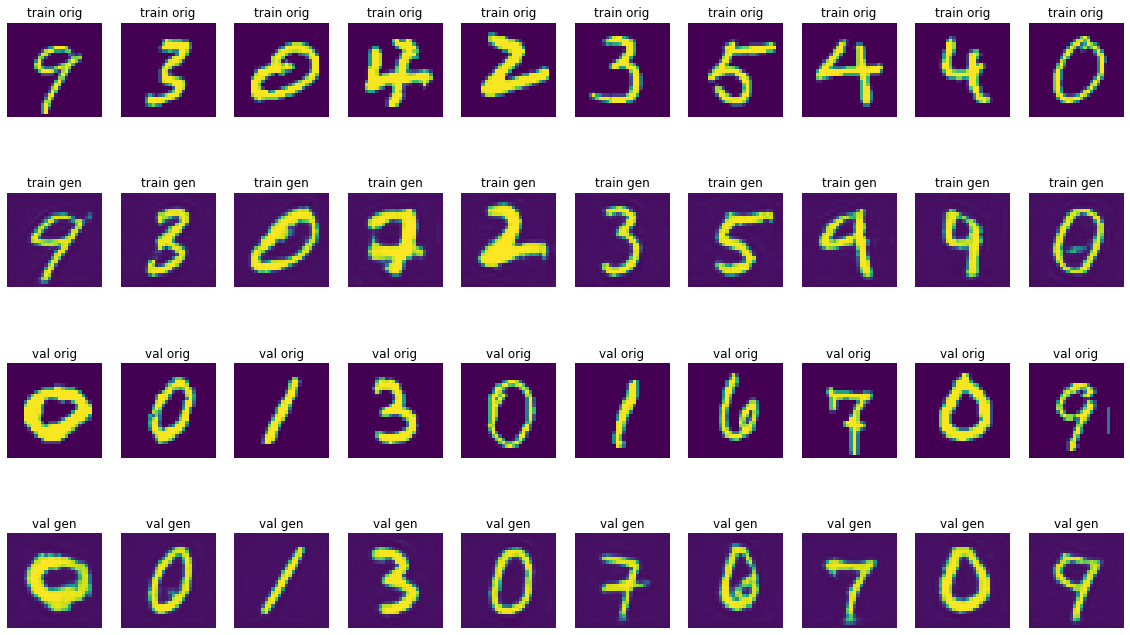

E: 0034 / B: 0004 - KL_Loss: 25.0351 - IMG_loss: 0.1849
                        val: 27.7501 -      val: 0.1767
	Gen_loss: 1.0123 - Disc_on_orig: 0.5657 - Disc_on_gen: 0.6666
	     val: 1.1987 -          val: 0.5438 -         val: 0.5022



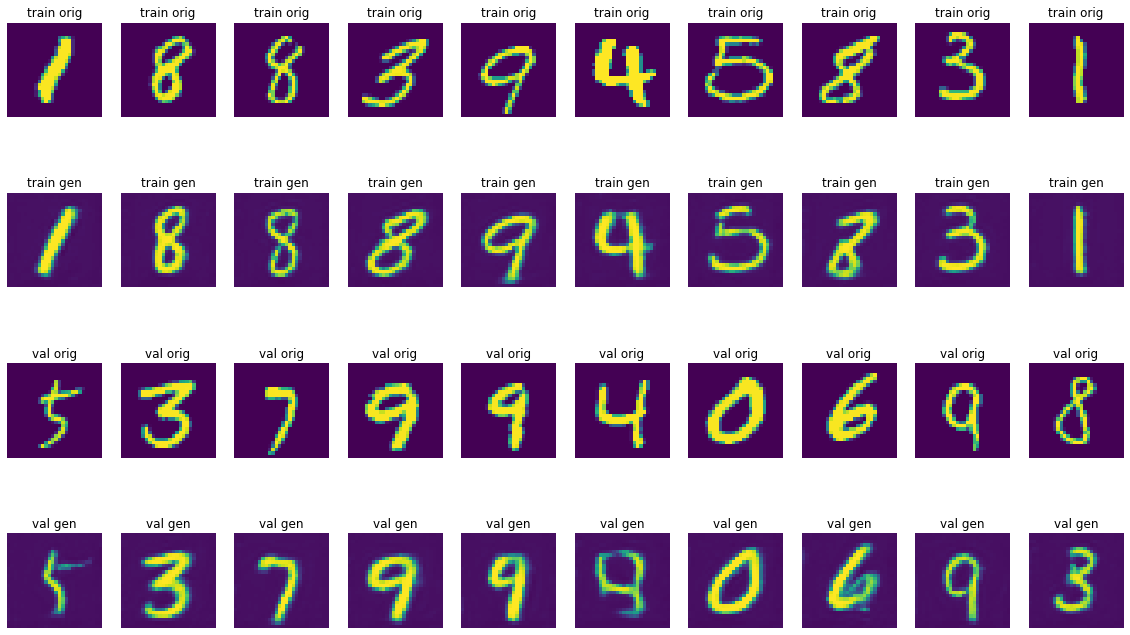

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0035 / B: 0004 - KL_Loss: 24.4061 - IMG_loss: 0.1819
                        val: 23.1914 -      val: 0.1883
	Gen_loss: 1.2368 - Disc_on_orig: 0.5455 - Disc_on_gen: 0.5556
	     val: 1.0021 -          val: 0.4221 -         val: 0.5448



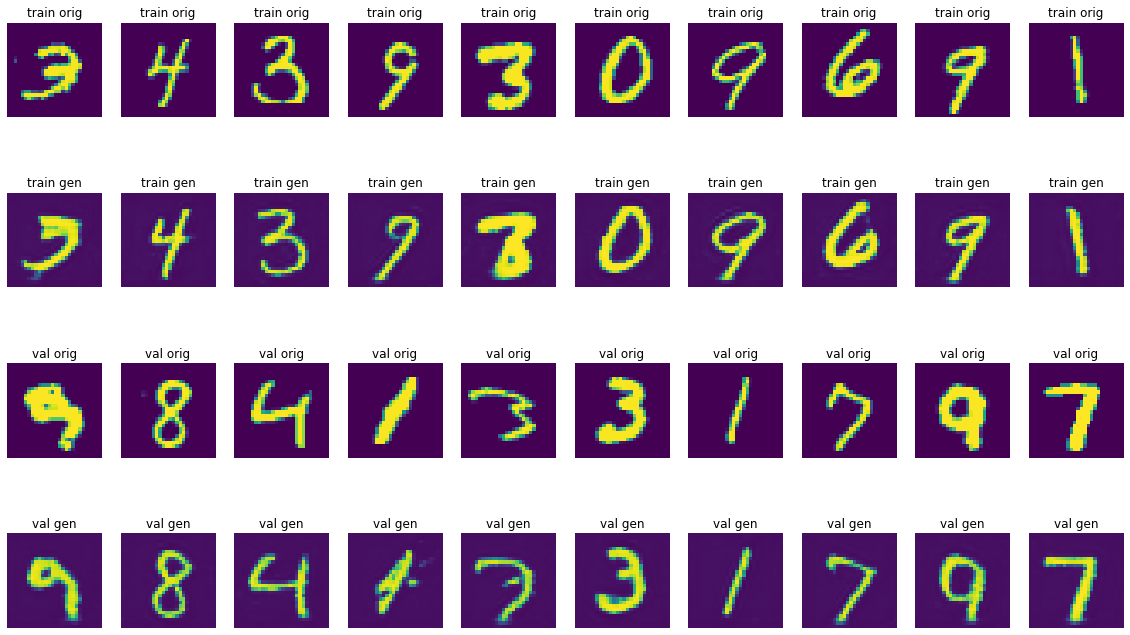

E: 0036 / B: 0004 - KL_Loss: 24.2595 - IMG_loss: 0.1821
                        val: 26.2213 -      val: 0.2220
	Gen_loss: 1.2330 - Disc_on_orig: 0.5542 - Disc_on_gen: 0.5266
	     val: 0.7225 -          val: 0.6865 -         val: 0.7162



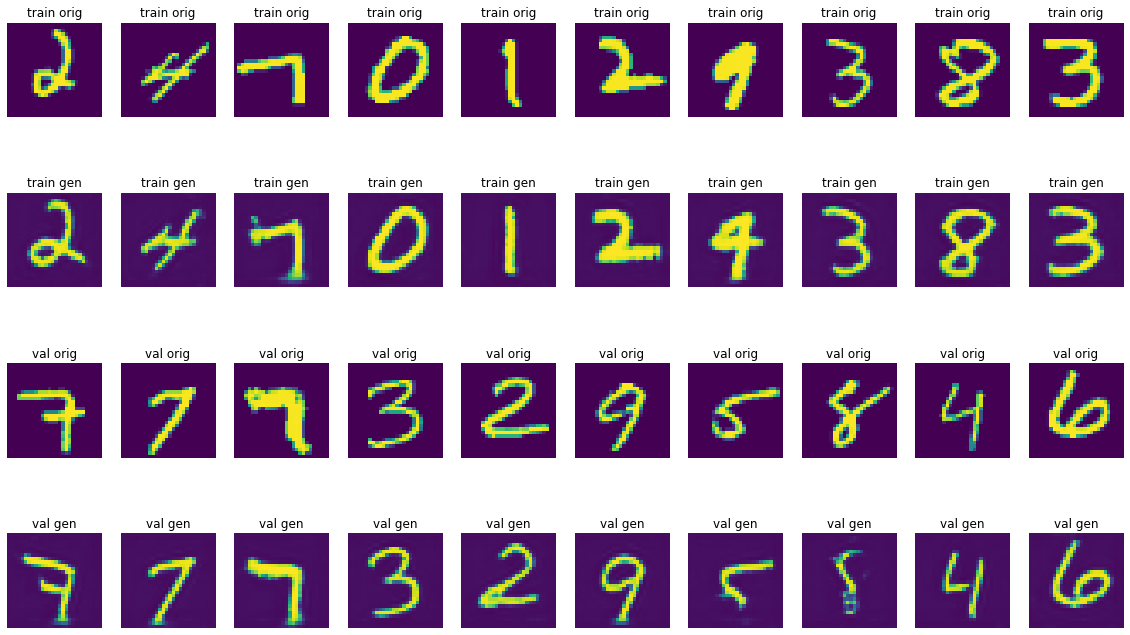

E: 0037 / B: 0004 - KL_Loss: 26.9381 - IMG_loss: 0.1883
                        val: 24.3609 -      val: 0.1917
	Gen_loss: 1.3595 - Disc_on_orig: 0.5315 - Disc_on_gen: 0.5339
	     val: 0.5539 -          val: 0.7000 -         val: 0.9790



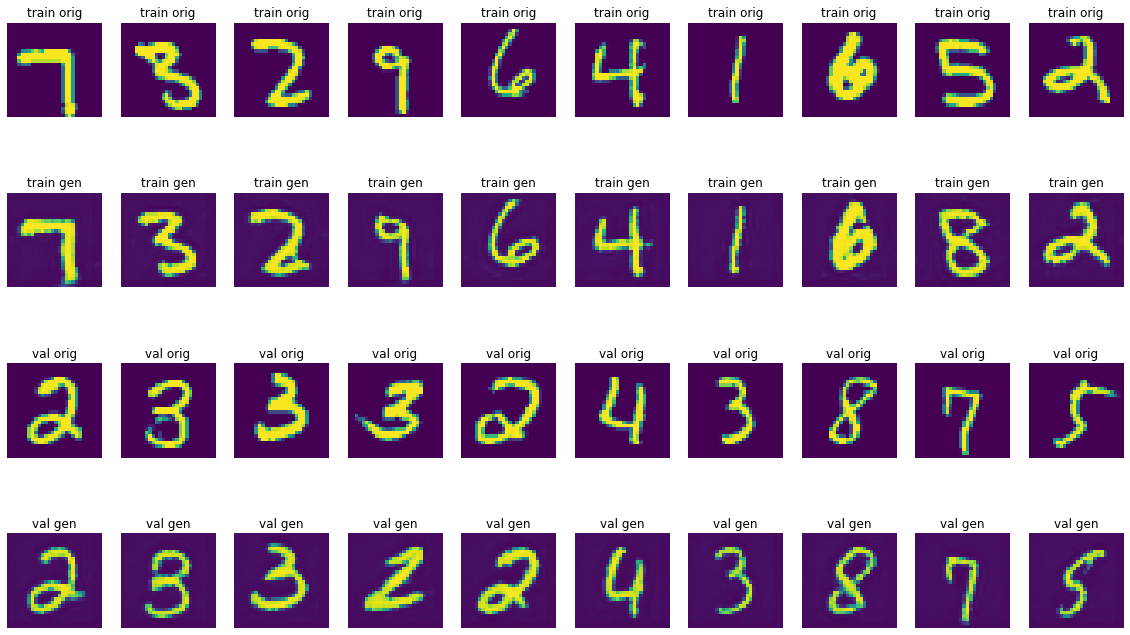

E: 0038 / B: 0004 - KL_Loss: 25.6668 - IMG_loss: 0.1779
                        val: 28.5545 -      val: 0.1731
	Gen_loss: 1.2365 - Disc_on_orig: 0.5271 - Disc_on_gen: 0.5635
	     val: 0.8575 -          val: 0.5629 -         val: 0.6346



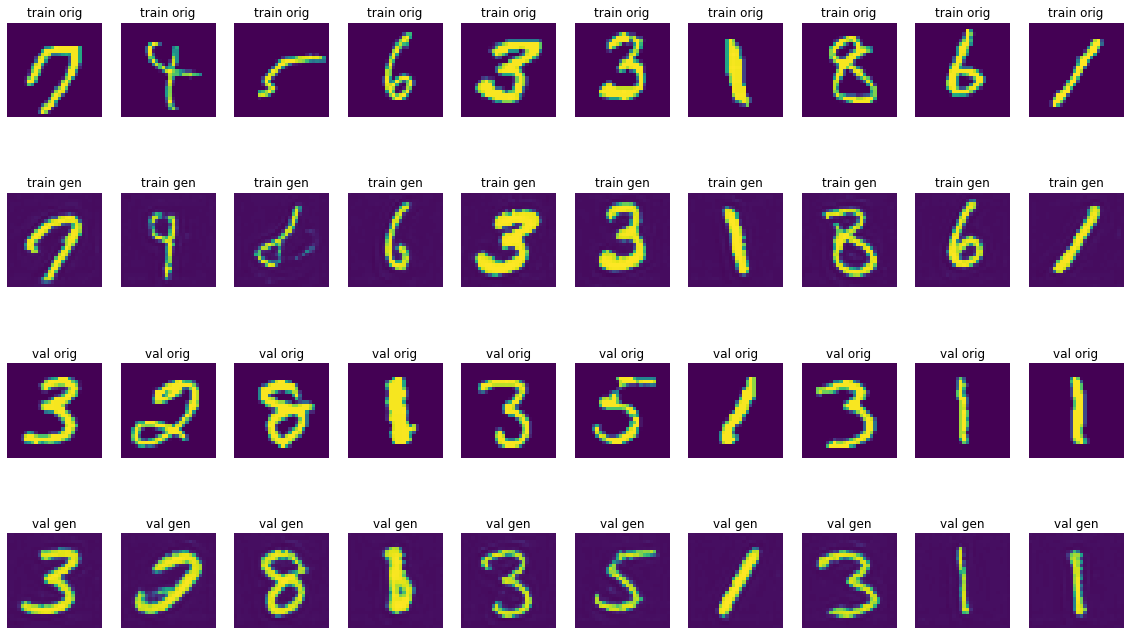

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0039 / B: 0004 - KL_Loss: 23.8264 - IMG_loss: 0.1729
                        val: 25.7233 -      val: 0.2426
	Gen_loss: 1.0984 - Disc_on_orig: 0.5301 - Disc_on_gen: 0.7108
	     val: 0.0111 -          val: 0.1818 -         val: 13.9208



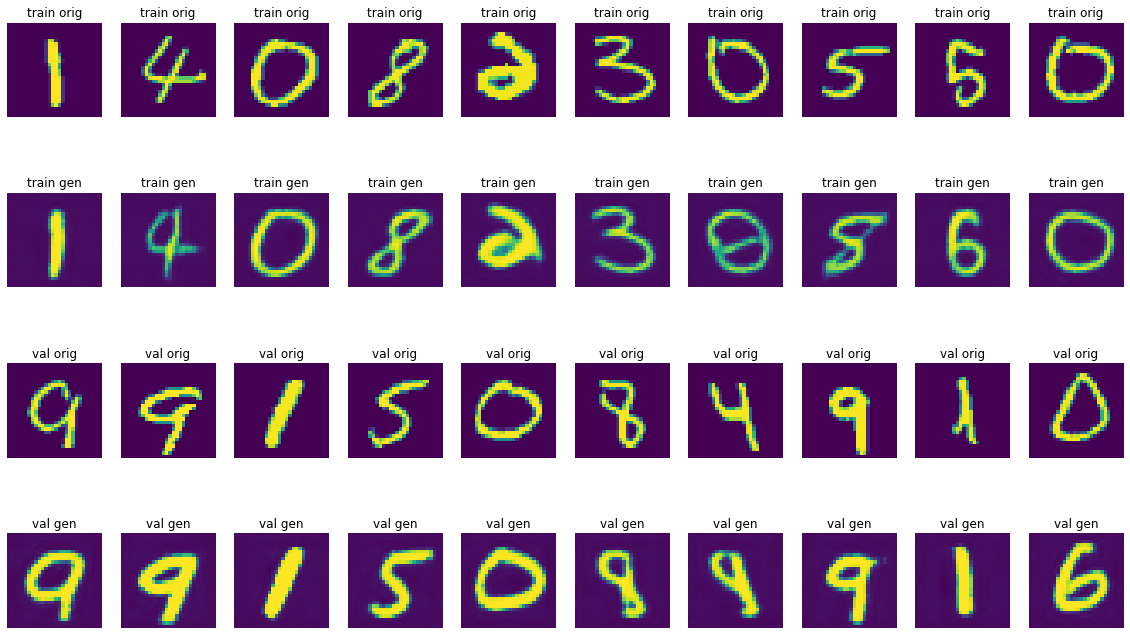

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_GLoss_discrim/assets
E: 0040 / B: 0004 - KL_Loss: 23.0725 - IMG_loss: 0.1669
                        val: 30.1762 -      val: 0.1779
	Gen_loss: 1.0096 - Disc_on_orig: 0.6129 - Disc_on_gen: 0.5482
	     val: 2.6707 -          val: 0.7029 -         val: 0.2111



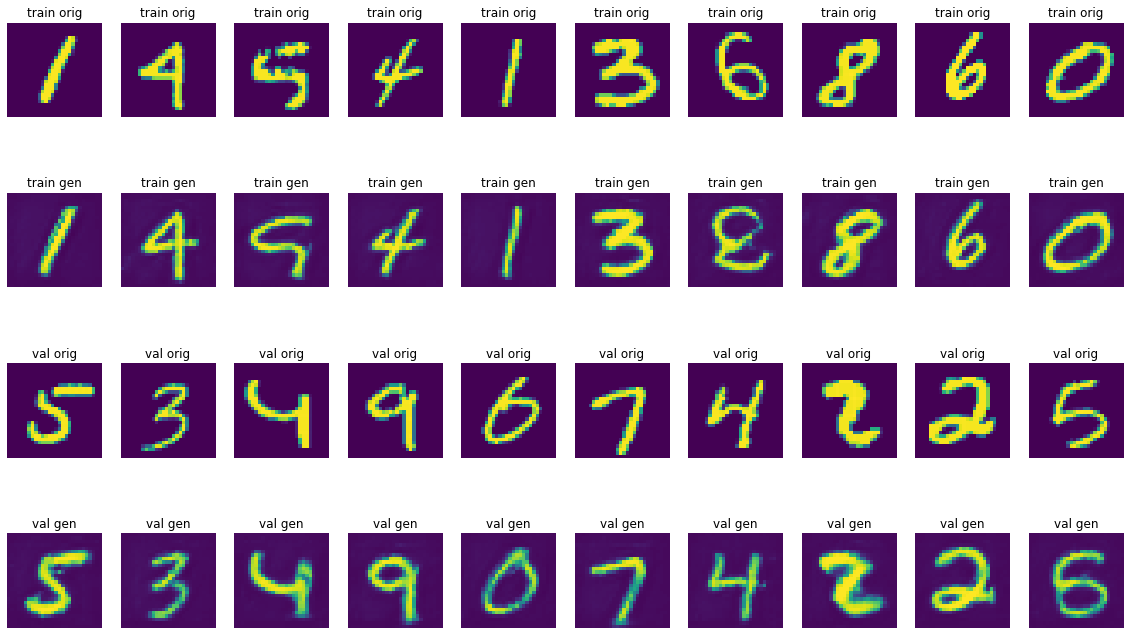

E: 0041 / B: 0004 - KL_Loss: 23.0867 - IMG_loss: 0.1729
                        val: 23.1098 -      val: 0.1885
	Gen_loss: 1.0421 - Disc_on_orig: 0.5748 - Disc_on_gen: 0.5467
	     val: 2.3769 -          val: 0.9770 -         val: 0.1951



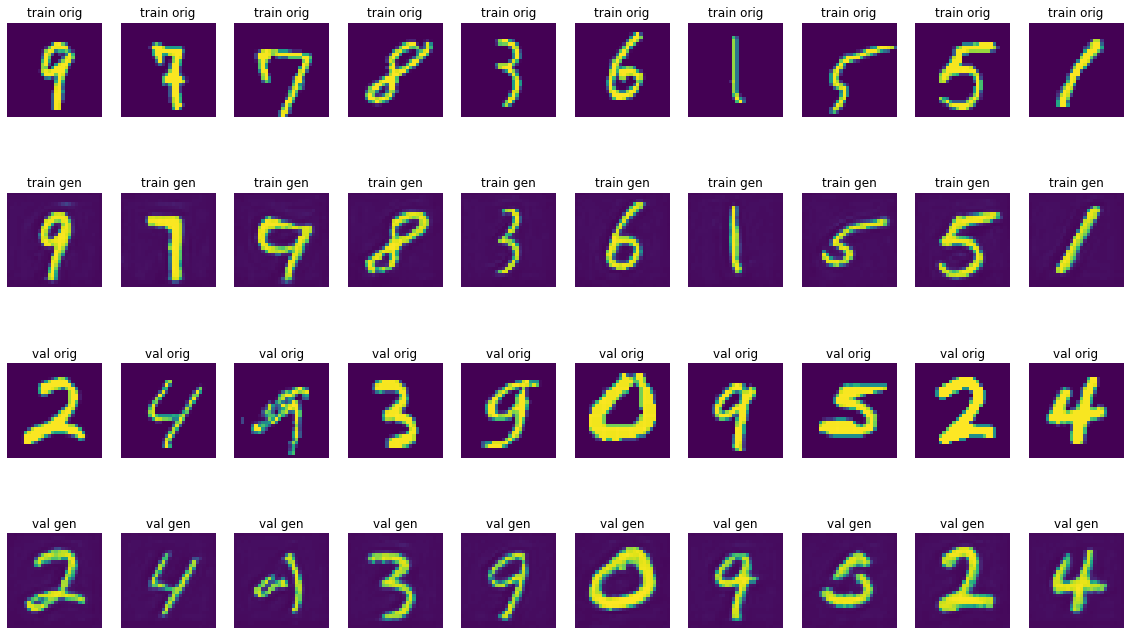

E: 0042 / B: 0004 - KL_Loss: 23.1346 - IMG_loss: 0.1709
                        val: 22.7360 -      val: 0.1671
	Gen_loss: 1.2309 - Disc_on_orig: 0.5621 - Disc_on_gen: 0.5256
	     val: 1.0203 -          val: 0.6982 -         val: 0.5297



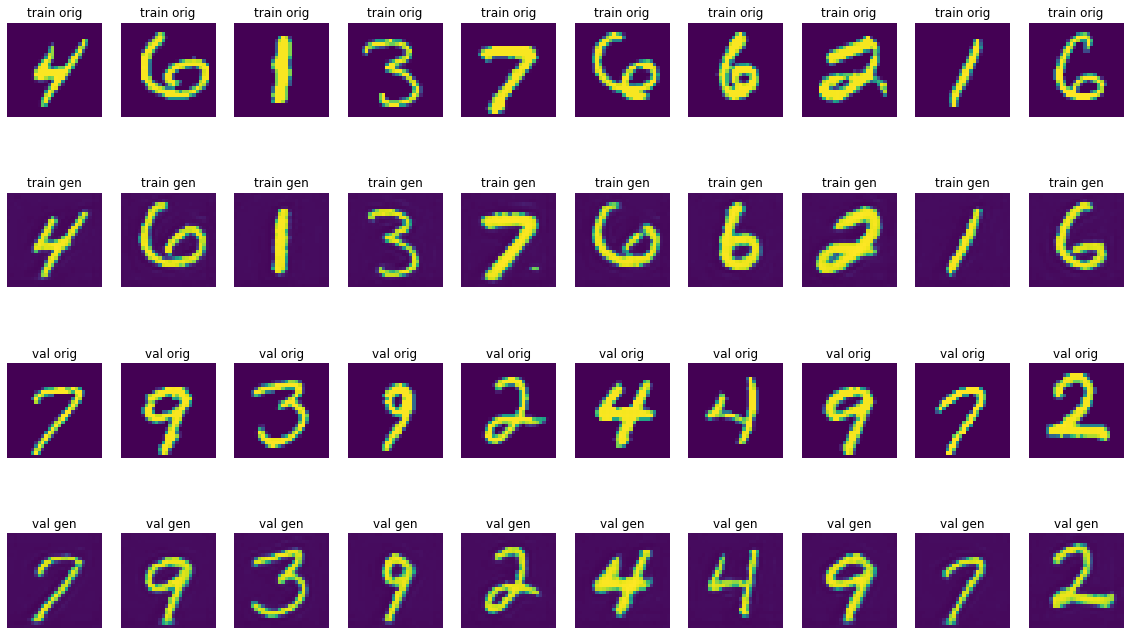

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0043 / B: 0004 - KL_Loss: 24.4015 - IMG_loss: 0.1714
                        val: 25.4322 -      val: 0.1800
	Gen_loss: 1.2610 - Disc_on_orig: 0.5441 - Disc_on_gen: 0.5438
	     val: 0.7675 -          val: 0.5479 -         val: 0.7188



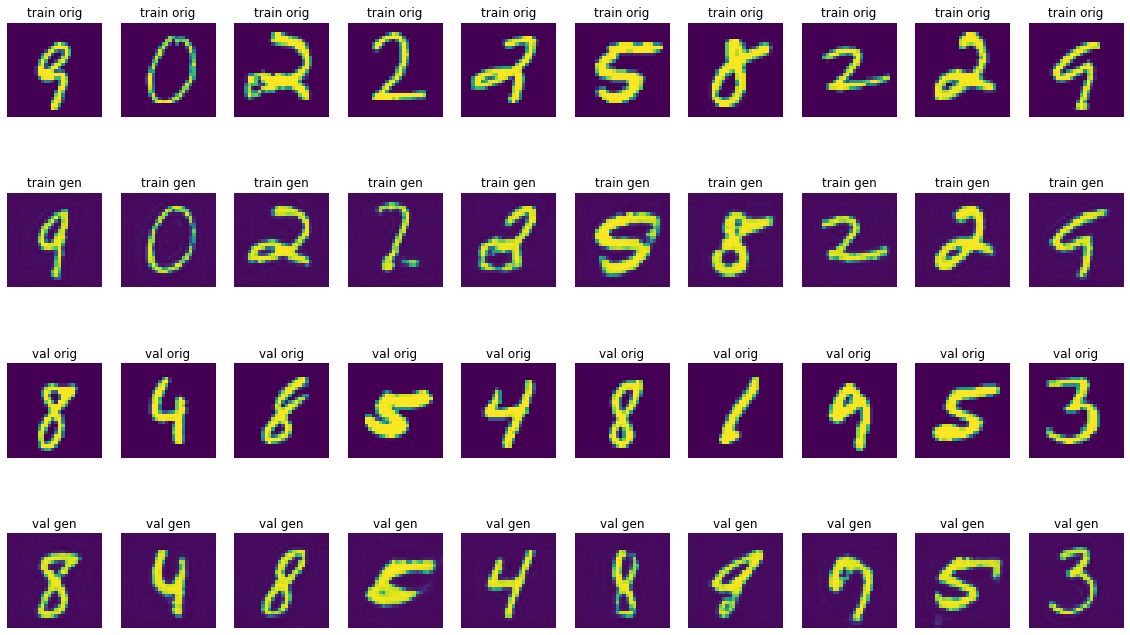

E: 0044 / B: 0004 - KL_Loss: 24.5993 - IMG_loss: 0.1688
                        val: 22.1964 -      val: 0.1642
	Gen_loss: 1.2002 - Disc_on_orig: 0.5464 - Disc_on_gen: 0.5637
	     val: 0.8696 -          val: 0.7522 -         val: 0.6014



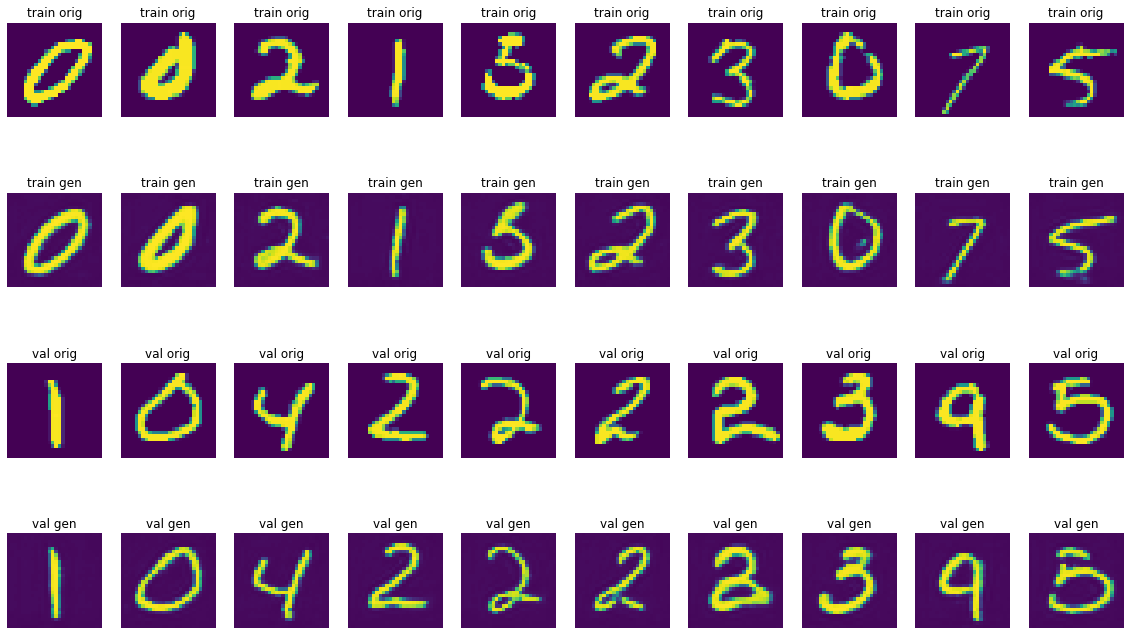

INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_decoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/BI_Master/Projeto/best2_discrim/assets
E: 0045 / B: 0004 - KL_Loss: 23.7397 - IMG_loss: 0.1699
                        val: 19.8378 -      val: 0.2393
	Gen_loss: 1.3692 - Disc_on_orig: 0.5935 - Disc_on_gen: 0.5524
	     val: 1.0087 -          val: 0.6462 -         val: 0.5875



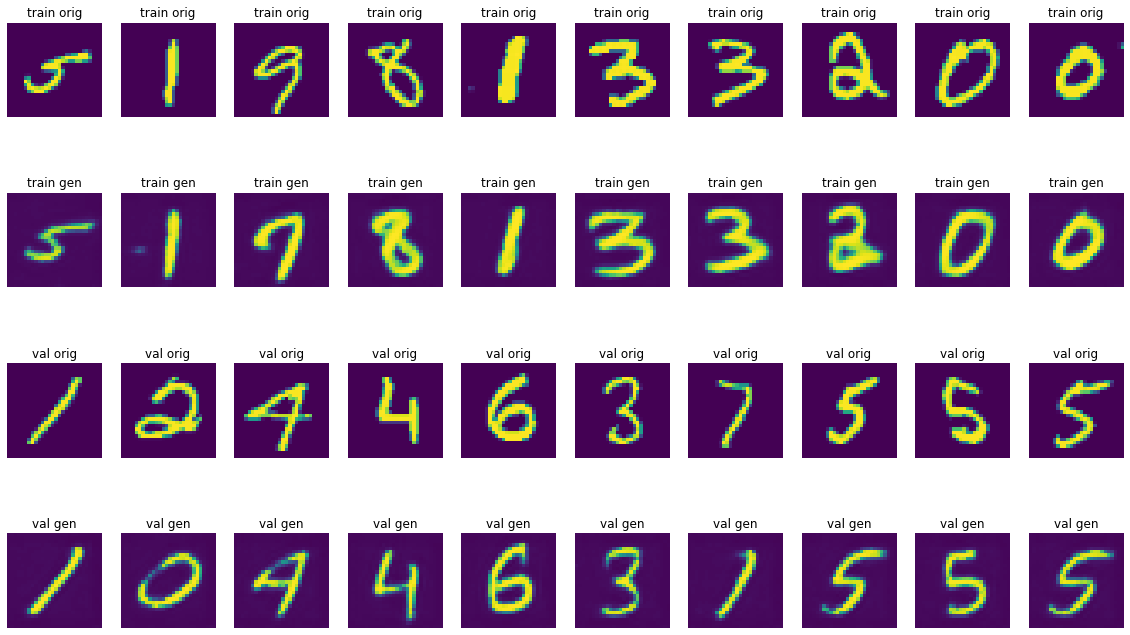

E: 0046 / B: 0004 - KL_Loss: 23.9684 - IMG_loss: 0.1723
                        val: 26.7849 -      val: 0.1808
	Gen_loss: 1.3435 - Disc_on_orig: 0.5102 - Disc_on_gen: 0.4729
	     val: 0.7647 -          val: 0.6373 -         val: 0.7251



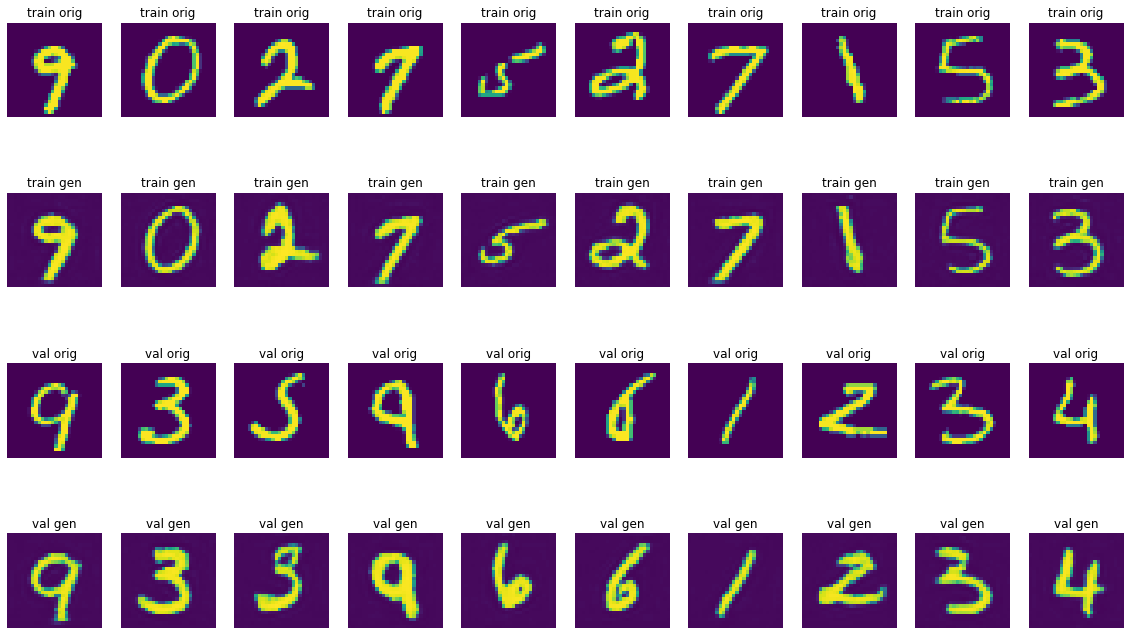

E: 0047 / B: 0004 - KL_Loss: 25.0568 - IMG_loss: 0.1736
                        val: 44.5166 -      val: 0.2707
	Gen_loss: 1.2835 - Disc_on_orig: 0.5108 - Disc_on_gen: 0.5499
	     val: 0.2688 -          val: 0.3105 -         val: 2.1806



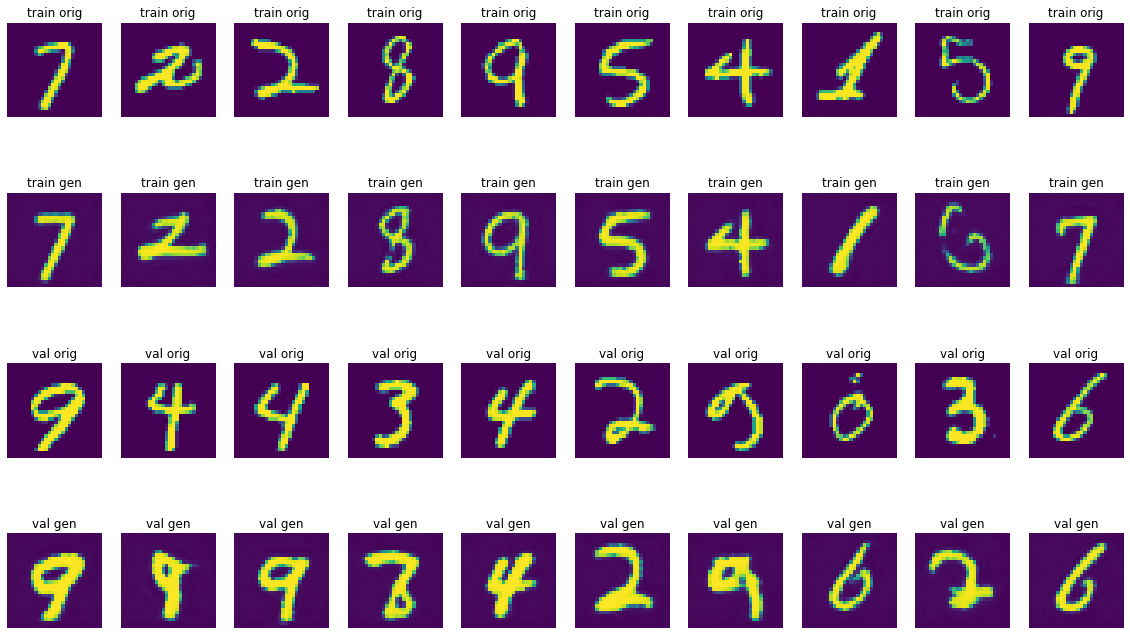

E: 0048 / B: 0004 - KL_Loss: 26.3430 - IMG_loss: 0.1849
                        val: 57.3117 -      val: 0.2517
	Gen_loss: 1.3790 - Disc_on_orig: 0.4708 - Disc_on_gen: 0.4814
	     val: 0.8094 -          val: 0.6281 -         val: 0.8755



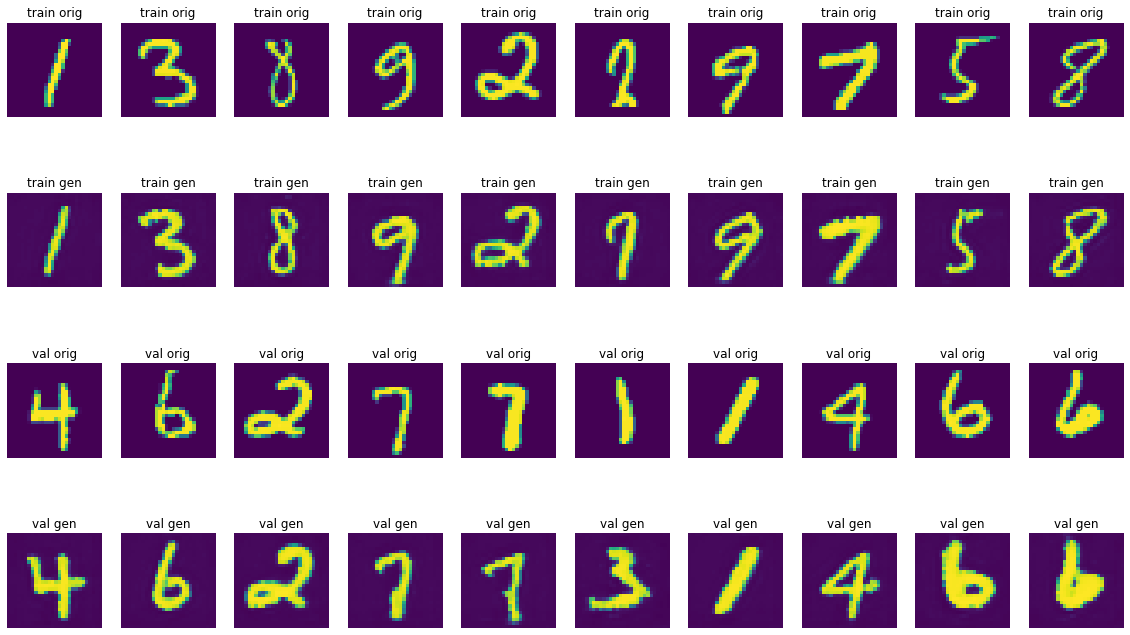

E: 0049 / B: 0004 - KL_Loss: 26.6148 - IMG_loss: 0.1839
                        val: 52.1613 -      val: 0.2184
	Gen_loss: 1.3294 - Disc_on_orig: 0.4979 - Disc_on_gen: 0.5011
	     val: 0.8748 -          val: 0.7570 -         val: 0.6414



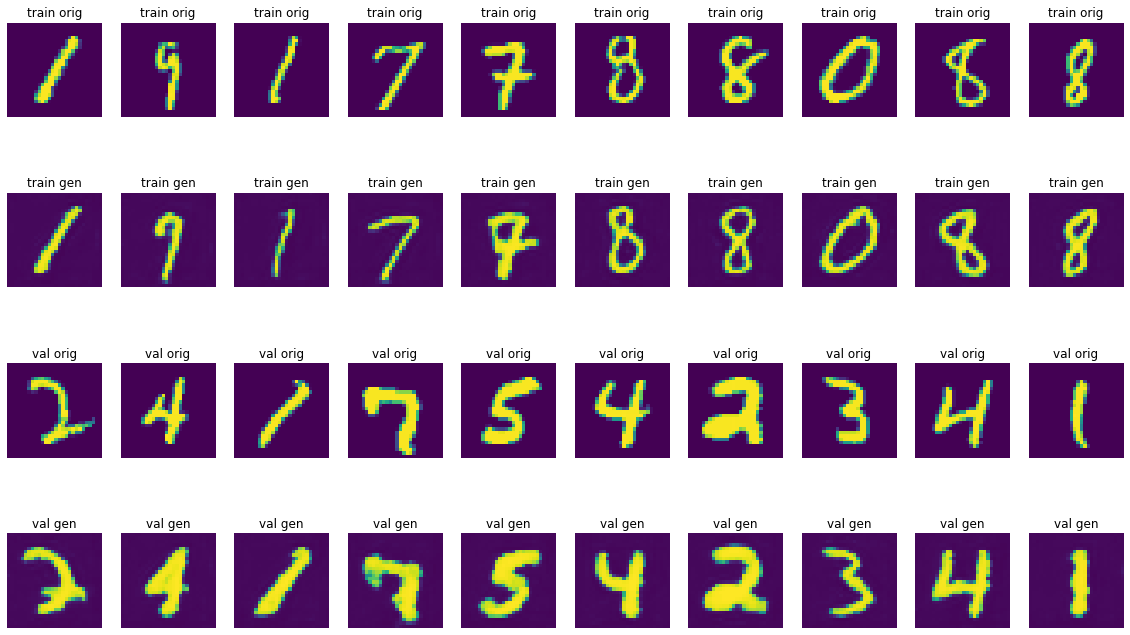

E: 0050 / B: 0004 - KL_Loss: 27.6919 - IMG_loss: 0.1804
                        val: 30.9401 -      val: 0.1804
	Gen_loss: 1.3609 - Disc_on_orig: 0.5556 - Disc_on_gen: 0.5460
	     val: 0.8785 -          val: 0.6364 -         val: 0.6724



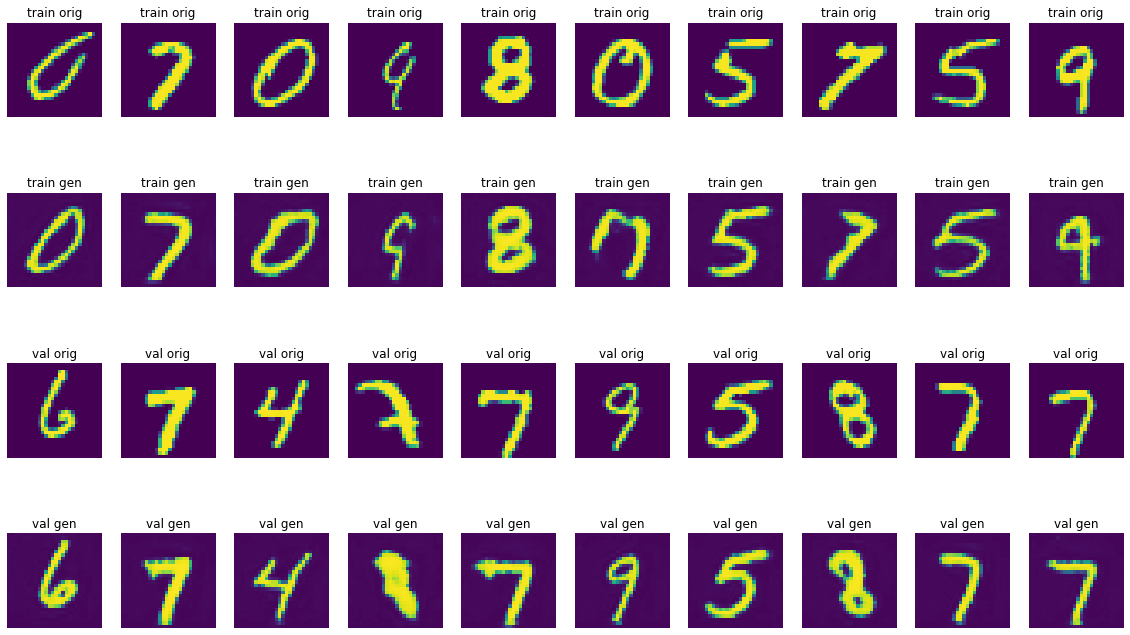

E: 0051 / B: 0004 - KL_Loss: 27.4598 - IMG_loss: 0.1782
                        val: 25.0653 -      val: 0.1819
	Gen_loss: 1.3378 - Disc_on_orig: 0.4979 - Disc_on_gen: 0.4857
	     val: 0.8562 -          val: 0.5218 -         val: 0.6144



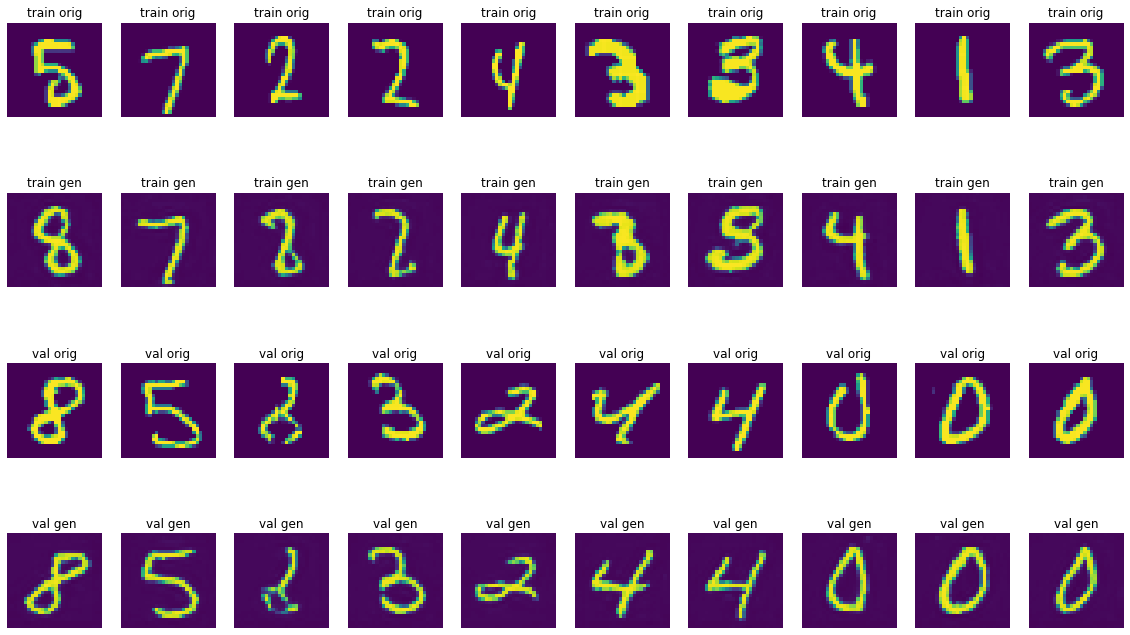

E: 0052 / B: 0004 - KL_Loss: 26.9918 - IMG_loss: 0.1723
                        val: 24.9364 -      val: 0.1758
	Gen_loss: 1.2676 - Disc_on_orig: 0.5161 - Disc_on_gen: 0.5185
	     val: 0.9385 -          val: 0.5180 -         val: 0.5956



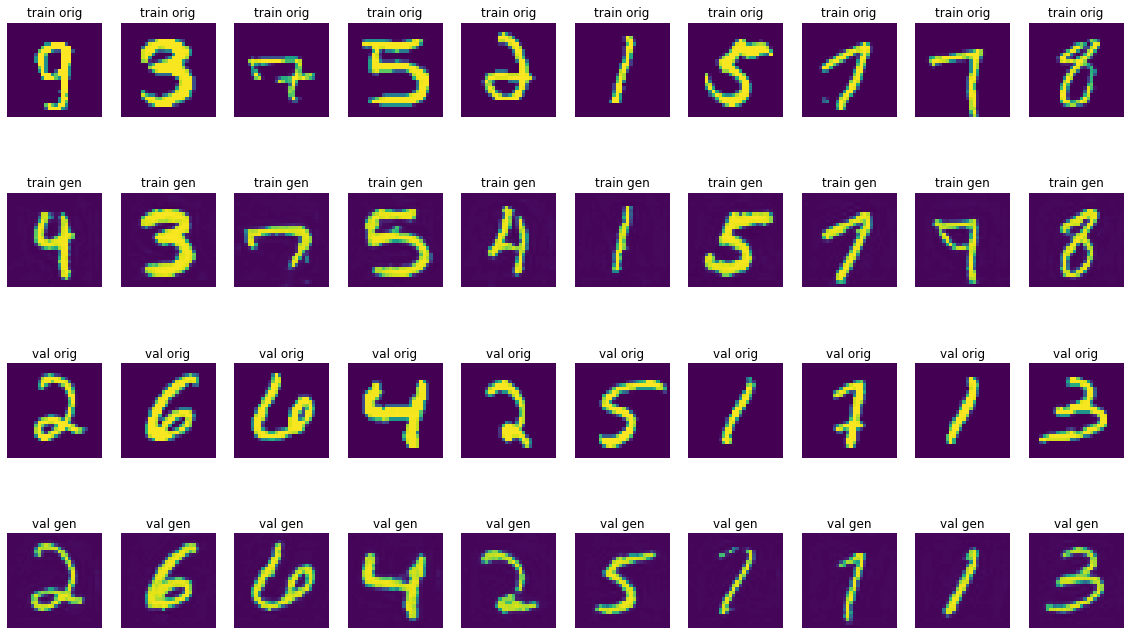

E: 0053 / B: 0004 - KL_Loss: 26.4743 - IMG_loss: 0.1695
                        val: 27.5198 -      val: 0.1806
	Gen_loss: 1.2281 - Disc_on_orig: 0.5345 - Disc_on_gen: 0.5697
	     val: 0.9047 -          val: 0.7082 -         val: 0.5979



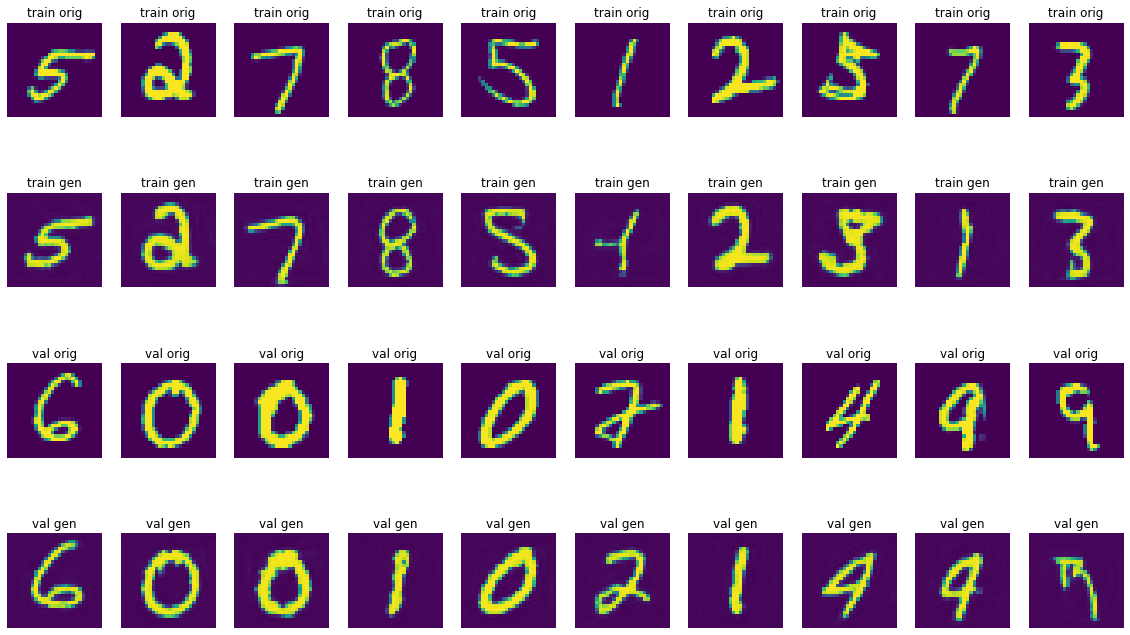

E: 0054 / B: 0004 - KL_Loss: 27.4510 - IMG_loss: 0.1764
                        val: 27.4671 -      val: 0.1775
	Gen_loss: 1.2480 - Disc_on_orig: 0.5493 - Disc_on_gen: 0.5334
	     val: 1.0817 -          val: 0.8838 -         val: 0.5174



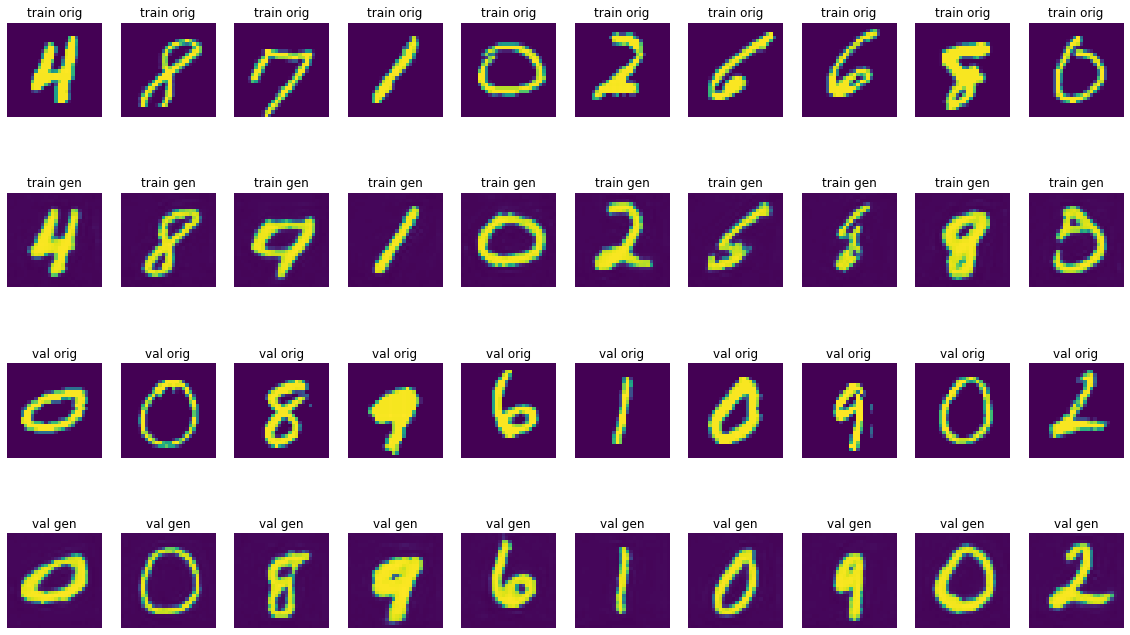

E: 0055 / B: 0004 - KL_Loss: 27.8888 - IMG_loss: 0.1741
                        val: 42.8170 -      val: 0.2091
	Gen_loss: 1.3143 - Disc_on_orig: 0.4962 - Disc_on_gen: 0.4860
	     val: 0.5823 -          val: 0.5155 -         val: 0.9854



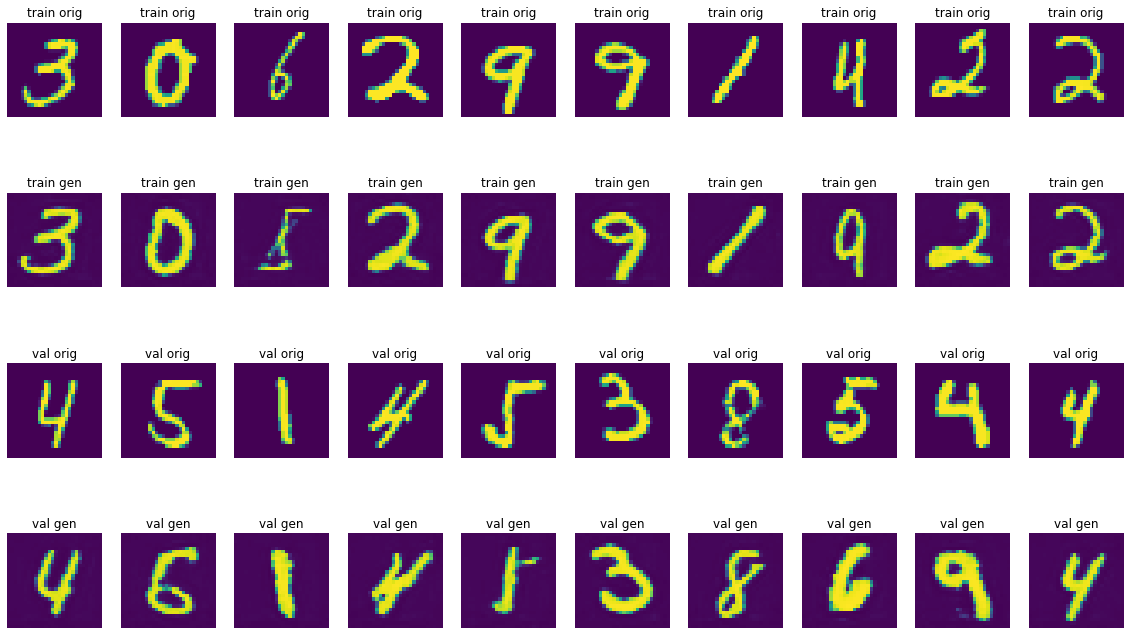

Stopping after 11 epochs without improvement in val img loss


In [ ]:
smallData = False
epochs = 100 #- talvez dê pra melhorar com mais épocas
patience = 10 #critério de parada para val loss de images geradas
batchSize = 600 if smallData == False else 50
batches = len(xTrain) // batchSize
nameForSaving = wDir + "/best2"

valBatchSize = 2000 if smallData == False else 50
valBatches = len(xTest) // valBatchSize

assert len(xTrain) % batchSize == 0
assert len(xTest) % valBatchSize == 0

print('total batches:', batches)
print("total val batches:", valBatches)
tf.keras.backend.set_floatx('float32')

trainCount = batches * batchSize if smallData == False else 2*batchSize
valCount = valBatches * valBatchSize if smallData == False else  2*valBatchSize
dataset = tf.data.Dataset.from_tensor_slices((xTrain[:trainCount], yTrain[:trainCount])).shuffle(trainCount).batch(batchSize)
valDataset = tf.data.Dataset.from_tensor_slices((xTest[:valCount], yTest[:valCount])).shuffle(valCount).batch(valBatchSize)


#lr = 1e-4
#one optimizer per model
encOptimizer = Adam()
decOptimizer = Adam()
discOptimizer = Adam()


#arrays to keep track of the losses
lossNames = ["KL_Loss", "IMG_Loss", "Gen_Loss", "Disc_on_Orig_Loss", "Disc_on_Gen_Loss"] #respectively L1, L2, L3, L4, L5
history = [[] for _ in lossNames] #one history list per loss
valHistory = [[] for _ in lossNames] #one history list per loss

bestValLoss = float("inf")
bestGenLoss = float("inf")
badLossCount = 0
firstStreak = True #don't save model before the loss stops decreasing at least once
for e in range(epochs):
    batchLosses = [[] for _ in lossNames] #for taking the mean loss of an epoch
    valBatchLosses = [[] for _ in lossNames]
    
    for b, (images, classes) in enumerate(dataset):

        #predictions, losses  and training
        outputs, losses = fullModel.trainPass(images, encOptimizer, decOptimizer, discOptimizer)    
        
        #adding losses to their respective histories
        for name, l, val in zip(lossNames, batchLosses, losses):
            l.append(K.mean(val).numpy())

    #mean losses for the epoch - one mean per loss name
    batchLosses = [np.mean(np.array(l)) for l in batchLosses]
    
    #update history - one history per loss name
    for h, l in zip(history,batchLosses):
        h.append(l)


    #validation pass
    for b, (valImages, classes) in enumerate(valDataset):
        valOutputs, losses = fullModel.predictPass(valImages)

        for name, l, val in zip(lossNames, valBatchLosses, losses):
            l.append(K.mean(val).numpy())
    valBatchLosses = [np.mean(np.array(l)) for l in valBatchLosses]
    for h, l in zip(valHistory, valBatchLosses):
        h.append(l)


    #print losses
    print('E: {:04d} / B: {:04d} - KL_Loss: {:.4f} - IMG_loss: {:.4f}'.format(e,b,batchLosses[0], batchLosses[1]))
    print('                        val: {:.4f} -      val: {:.4f}'.format(valBatchLosses[0], valBatchLosses[1]))
    print('\tGen_loss: {:.4f} - Disc_on_orig: {:.4f} - Disc_on_gen: {:.4f}'.format(batchLosses[2]   , batchLosses[3]   , batchLosses[4]))
    print('\t     val: {:.4f} -          val: {:.4f} -         val: {:.4f}'.format(valBatchLosses[2], valBatchLosses[3], valBatchLosses[4]))
    print('')

    #plot results
    toPlot = np.concatenate([images[:10], outputs[3][:10], valImages[:10], valOutputs[3][:10]])
    plotLabels = np.array(["train orig"]*10 + ["train gen"]*10 + ["val orig"]*10 + ["val gen"]*10)
    plot40(toPlot, plotLabels, False)

    #stop and save criteria
    l = valHistory[1][-1] #last from valIMGLoss
    if l < bestValLoss:
        bestValLoss = l
        badLossCount = 0
        imageBad = False
        if firstStreak == False:
            fullModel.saveModels(nameForSaving)
    else:
        firstStreak = False
        imageBad = True

    
    l = valHistory[2][-1] #last from valGenLoss
    if l < bestGenLoss:
        bestGenLoss = l
        badLossCount = 0
        if firstStreak == False:
            fullModel.saveModels(nameForSaving+"_GLoss")
    else:
        if imageBad == True:
            badLossCount += 1
    
    if badLossCount > patience: #if patience = 0, stops imediately
        print('Stopping after', badLossCount, 'epochs without improvement in val img loss')
        break


## Visualizing training history

Because the losses have significantly different scales, we normalize the history before showing. 

Since many of these losses compete against each other, only the IMG_loss (L2 - the loss that compares generated images with their respective true images) is taken into account when deciding when to stop training.    

In the charts:

- KL_Loss = L1   
- IMG_Loss = L2   
- Gen_Loss = L3   
- Disc_on_Orig_Loss = L4
- Disc_on_Gen_Loss = L5

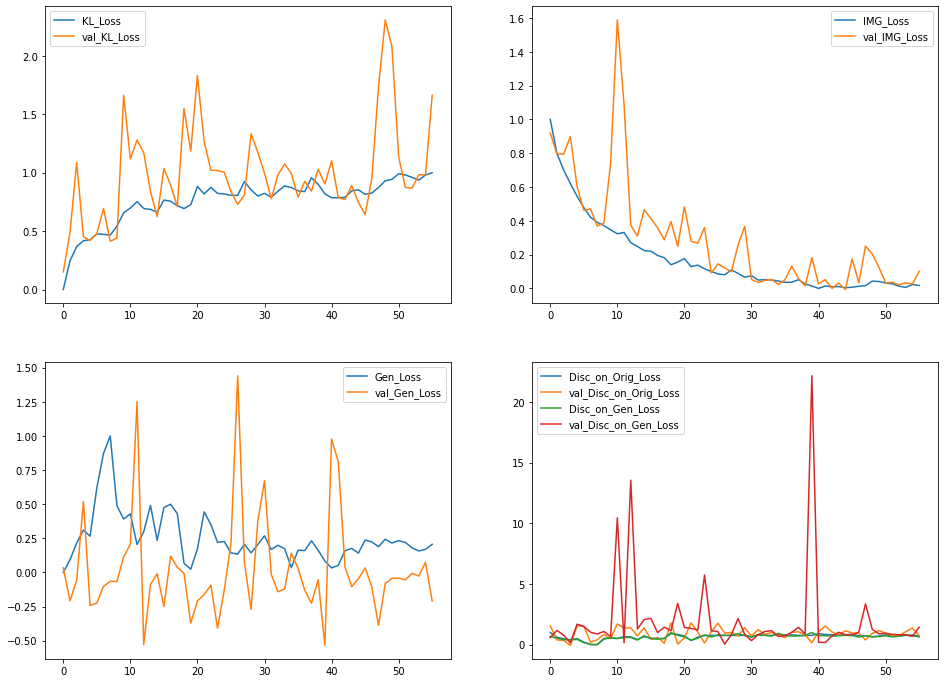

In [ ]:
def normalizeHistory(hist, valHist):
    hist = [np.array(h) for h in hist]
    valHist = [np.array(h) for h in valHist]

    mins = [h.min() for h in hist]
    maxes = [h.max() for h in hist]
    hist = [(h-mi)/(ma-mi) for h, mi, ma in zip(hist, mins, maxes)]
    valHist = [(h-mi)/(ma-mi) for h, mi, ma in zip(valHist, mins, maxes)]
    return hist, valHist

nHistory, nValHistory = normalizeHistory(history, valHistory)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

def plotLoss(ax, *l):
    for i in l:
        ax.plot(nHistory[i], label=lossNames[i])
        ax.plot(nValHistory[i], label = "val_" + lossNames[i])
    ax.legend()
plotLoss(axes[0,0], 0)
plotLoss(axes[0,1], 1)
plotLoss(axes[1,0], 2)
plotLoss(axes[1,1], 3, 4)
plt.show()

## Training conclusion

Since we are training a GAN, it's normal to see some losses not decreasing as usually expected when training neural networks. 

GAN losses for the generator and discriminator (**L3**, **L4** and **L5**, respectively `Gen_Loss`, `Disc_on_Orig_Loss` and `Disc_on_Gen_loss` in the image above) are competing losses. When the generator gets better, the discriminator losses tend to get worse and vice versa. 

Similarly, the Kullback-Leibler (**L1**) loss also competes with the produced images loss (**L2**) in some way, although in this case there is room for the image loss to decrease. 

Because of this, the only loss that actually tells us about the training quality is the image loss (**L2**). We can see it decreased and stabilized. 

Looking at the generated images, we can see that the training was satisfactory, and the model is capable of generating high quality images. 

In the second part of this work, we will use this model to study the encoded parameters and manipulate them to generate images with desired traits.